# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Select whether to read saved offer categorizations (fast) or carry out catgorization (takes about an hour)

In [2]:
# set flag to true to read saved person/offer organized info. this flag is input to function organize_offers later.
# if set to False, the organized results are recomputed and saved to a pickle file.
# any previously save catgorization is overwritten.
# setting the flag to False add about one hour of run time.
read_saved_person_offer = True

## Examine portfolio data frame

In [3]:
portfolio.shape

(10, 6)

In [4]:
# there are only ten rows. look at the entire data frame.
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


#### There are no missing entries in portfolio.

In [5]:
# what are the levels of difficulty?
print('there are {} levels of difficulty'.format(portfolio['difficulty'].nunique()))
print('the levels of difficulty are: {}'.format(portfolio['difficulty'].unique().tolist()))

there are 5 levels of difficulty
the levels of difficulty are: [10, 0, 5, 20, 7]


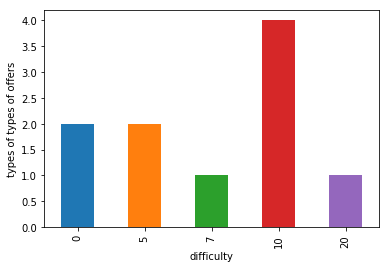

In [6]:
portfolio.groupby('difficulty')['id'].count().plot(kind='bar')
plt.xlabel('difficulty')
plt.ylabel('types of types of offers');

In [7]:
# what are the offer types?
print('there are {} types of offers'.format(portfolio['offer_type'].nunique()))
print('the types of offers are: {}'.format(portfolio['offer_type'].unique().tolist()))

there are 3 types of offers
the types of offers are: ['bogo', 'informational', 'discount']


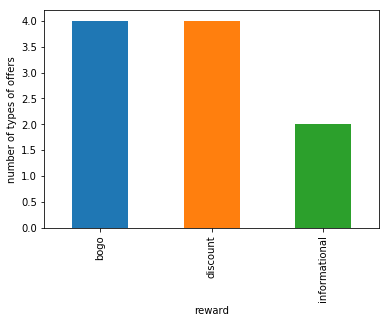

In [8]:
portfolio.groupby('offer_type')['id'].count().plot(kind='bar')
plt.xlabel('reward')
plt.ylabel('number of types of offers');

In [9]:
# what are the reward thresholds?
print('there are {} reward thresholds'.format(portfolio['reward'].nunique()))
print('the reward thresholds are: {}'.format(portfolio['reward'].unique().tolist()))

there are 5 reward thresholds
the reward thresholds are: [10, 0, 5, 3, 2]


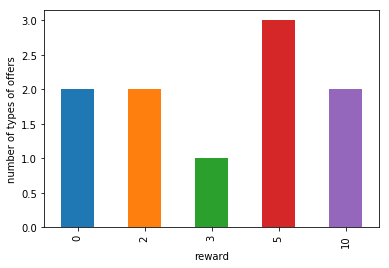

In [10]:
portfolio.groupby('reward')['id'].count().plot(kind='bar')
plt.xlabel('reward')
plt.ylabel('number of types of offers');

In [11]:
# what are the durations?
print('there are {} durations'.format(portfolio['duration'].nunique()))
print('the durations are: {}'.format(portfolio['duration'].unique().tolist()))

there are 5 durations
the durations are: [7, 5, 4, 10, 3]


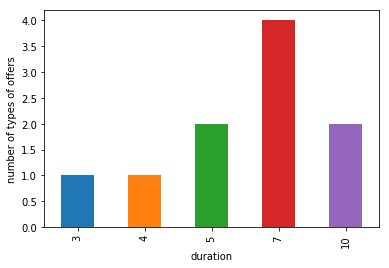

In [12]:
portfolio.groupby('duration')['id'].count().plot(kind='bar')
plt.xlabel('duration')
plt.ylabel('number of types of offers');

In [13]:
# get a list of the channels
channel_list = set()
for channels in portfolio['channels']:
    channel_list.update(channels)

channel_list = list(channel_list)
channel_list

['email', 'mobile', 'web', 'social']

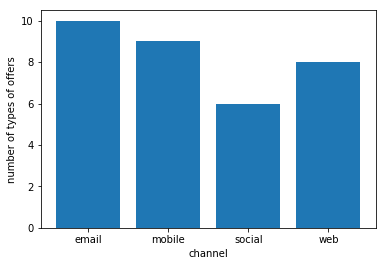

In [14]:
# how many types of offers carry each channel?
channel_freq = dict.fromkeys(channel_list, 0)
for channel in channel_list:
    for offer in portfolio['channels']:
        if channel in offer:
            channel_freq[channel] = channel_freq[channel] + 1
    
plt.bar(channel_freq.keys(), channel_freq.values())
plt.xlabel('channel')
plt.ylabel('number of types of offers');

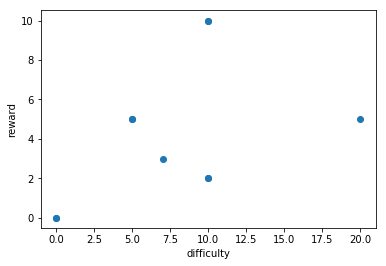

In [15]:
# relationship between difficulty and reward threshold
plt.scatter(portfolio['difficulty'], portfolio['reward'])
plt.xlabel('difficulty')
plt.ylabel('reward');

Roughly speaking, higher difficulty translates into higher reward.

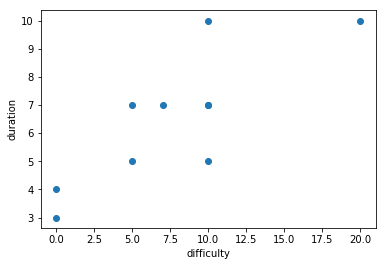

In [16]:
# relationship between difficulty and duration
plt.scatter(portfolio['difficulty'], portfolio['duration'])
plt.xlabel('difficulty')
plt.ylabel('duration');

Roughly speaking, higher difficulty is associated with longer duration.

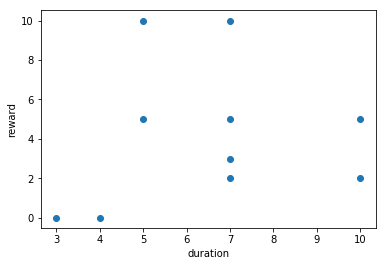

In [17]:
# relationship between duration and reward threshold
plt.scatter(portfolio['duration'], portfolio['reward'])
plt.xlabel('duration')
plt.ylabel('reward');

There is no strong relationship between reward and duration.

## Examine profile data frame

In [18]:
profile.shape

(17000, 5)

In [19]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [20]:
# missing age has been coded as 118. replace 118s by nan. presumably, no custome is 118 years old.
profile['age'] = np.where(profile['age'] == 118, np.nan, profile['age'])

In [21]:
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [22]:
profile.describe()

,age,became_member_on,income
count,14825.000000,1.700000e+04,14825.000000
mean,54.393524,2.016703e+07,65404.991568
std,17.383705,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016053e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


Highest income is $120,000. Why aren't there customers with higher incomes in the data set? Were they not targeted?

Age and income may have been input when the customer became a member, and may have not been updated since then.

It will be assumed that the customer entered their date of birth at the time of becoming a member, and Starbuck's system has calculated the age as of the promotion date. If not, the age is incorrect, is a souce of error, and would have to updated as of he promotion date.

If income has not been updated, income could be significantly different, especially for the earliest members, and a source of error in the analysis. It will be assumed that income data is current as of the promotion date.

In [23]:
# how many missing values in each column?
print('there are {} missing values for age'.format(profile.shape[0] - profile['age'].count()))
print('there are {} missing values for became_member_on'.format(profile.shape[0] - profile['became_member_on'].count()))
print('there are {} missing values for income'.format(profile.shape[0] - profile['income'].count()))

there are 2175 missing values for age
there are 0 missing values for became_member_on
there are 2175 missing values for income


In [24]:
# are the missing age and income data in the same rows?
print('{} rows are missing both age and income'.format(profile[(profile['age'].isna()) & (profile['income'].isna())]['became_member_on'].count()))

2175 rows are missing both age and income


If age is missing, so is income, and vice versa.

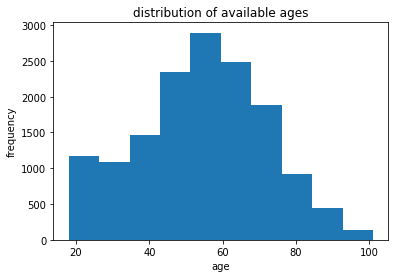

In [25]:
# plot the distribution of available ages
plt.hist(profile['age'].dropna())
plt.title('distribution of available ages')
plt.xlabel('age')
plt.ylabel('frequency');

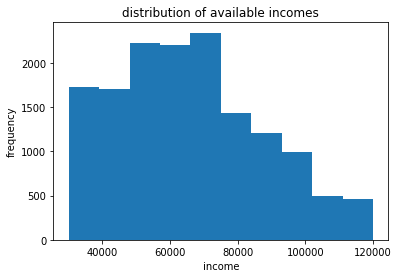

In [26]:
# plot the distribution of available incomes
plt.hist(profile['income'].dropna())
plt.title('distribution of available incomes')
plt.xlabel('income')
plt.ylabel('frequency');

### The age distribution is skewed towards younger customers. If older customers are more reluctant to provide their age, the missing data could have a bias towards older customers. Or, is it that younger customers are more reluctant to provide age and income information? This could affect how we fill in missing age and income values.

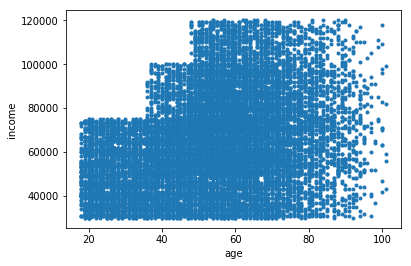

In [27]:
# plot the available incomes against age
plt.scatter(profile['age'].dropna(), profile['income'].dropna(), marker='.')
plt.xlabel('age')
plt.ylabel('income');

The stair-step behavior is odd. Can't fugure out what is causing it.

In [28]:
# https://www.pewresearch.org/internet/2019/11/15/americans-and-privacy-concerned-confused-and-feeling-lack-of-control-over-their-personal-information/

In [29]:
# create columns for year, month and day became member
profile['became_member_day'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.day
profile['became_member_month'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.month
profile['became_member_year'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.year

In [30]:
profile.head()

,age,became_member_on,gender,id,income,became_member_day,became_member_month,became_member_year
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,12,2,2017
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,15,7,2017
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,12,7,2018
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,9,5,2017
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,4,8,2017


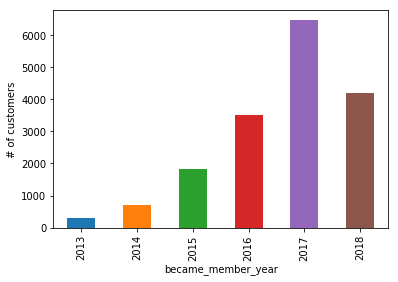

In [31]:
# plot distribution of year in which customers became a member
profile.groupby(['became_member_year'])['id'].count().plot(kind='bar')
plt.ylabel('# of customers');

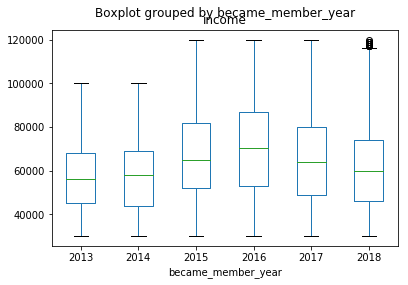

In [32]:
# make a boxplot of income distribution by became_member_year
profile.boxplot(by='became_member_year', column='income', grid=False);

Odd that maximum income in 2013-joiners and 2014-joiners is 100K and jumps to 120K from 2015 onward.

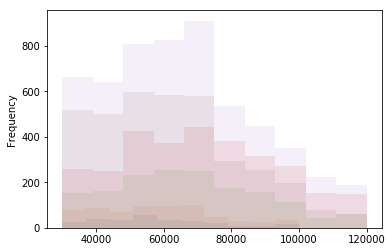

In [33]:
profile.groupby('became_member_year')['income'].plot.hist(alpha=0.1);

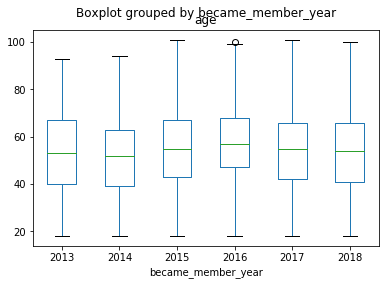

In [34]:
# make a boxplot of age distribution by became_member_year
profile.boxplot(by='became_member_year', column='age', grid=False);

Looks ok.

In [35]:
# get statistics for the gender column
profile['gender'].describe()

count     14825
unique        3
top           M
freq       8484
Name: gender, dtype: object

In [36]:
# what are the values for gender?
print('the values for gender are {}'.format(profile['gender'].unique().tolist()))

the values for gender are [None, 'F', 'M', 'O']


In [37]:
# how many values of each type?
profile.groupby('gender')['id'].count()

gender
F    6129
M    8484
O     212
Name: id, dtype: int64

In [38]:
#There are rows without gender value. Are these the same as the rows without age and income data?
print('{} rows are missing age, income and gender'.format(profile[(profile['gender'].isna()) & (profile['age'].isna()) & (profile['income'].isna())]['became_member_on'].count()))

2175 rows are missing age, income and gender


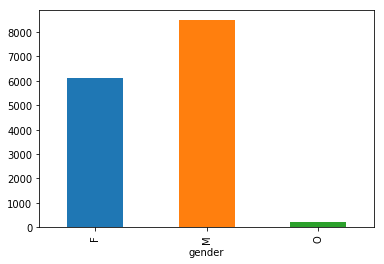

In [39]:
# plot gender distribution
profile.groupby('gender')['id'].count().plot.bar();

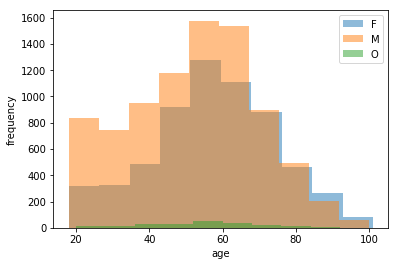

In [40]:
# plot age by gender
profile.groupby('gender')['age'].plot.hist(alpha=0.5)
plt.xlabel('age')
plt.ylabel('frequency')
plt.legend();

There are more males than females in the younger age groups.

As a gender, females are skewed toward higher ages, compared to males.

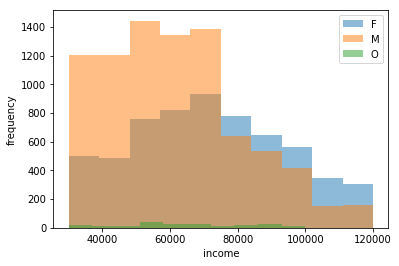

In [41]:
# plot income by gender
profile.groupby('gender')['income'].plot.hist(alpha=0.5)
plt.xlabel('income')
plt.ylabel('frequency')
plt.legend();

There are more males than females in the lower income groups.

Within gender, females are skewed towards higher income compared to males.

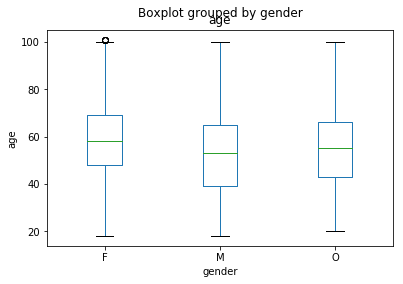

In [42]:
# make a boxplot of age distribution by gender
profile.boxplot(by='gender', column='age', grid=False)
plt.ylabel('age');

Male ages are skewed younger than female ages. Other gender ages are also skewed younger than female ages, and are roughly comparable to male ages.

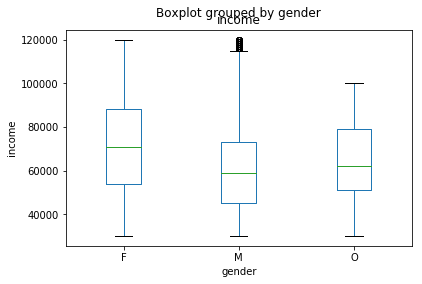

In [43]:
# make a boxplot of income distribution by gender
profile.boxplot(by='gender', column='income', grid=False)
plt.ylabel('income');

Male incomes are skewed lower than female incomes. Other gender incomes are also skewed lower than female incomes, but higher than male incomes.

Is there any commonality between the rows that are missing age, income and gender? The only remaining column that may indicate commonality is, perhaps, 'became_member_year'

In [44]:
profile[profile['age'].isna()]['became_member_year'].unique()

array([2017, 2018, 2016, 2015, 2014, 2013])

The missing values are spread out over many years. There is no discernible pattern.

### Check if the profile data fall into any groups. The relevant customer attributes are age, income, gender and became_member_year. So far, the exploratory work has not indicated any relationships, but let's double check.

Two methods will be used - PCA and K-Means. We are looking for grouping tendency. This info will not (yet) be used to make any predictions. The entire profile data frame will be used (less the missing rows) without dividing it into a training set and a test set.

In [45]:
# drop rows with missing data. if data is missing, age, gender and income are all missing, as observed earlier.
df_profile_groups = profile.dropna(axis=0).copy()

# delete the became_member_on, became_member_day and became_member_month columns
df_profile_groups.drop(columns=['became_member_on', 'became_member_day', 'became_member_month'], inplace = True)

# create categorical columns for gender
df_profile_groups['M'] = df_profile_groups['gender'].apply(lambda g: 1 if g == 'M' else 0)
df_profile_groups['F'] = df_profile_groups['gender'].apply(lambda g: 1 if g == 'F' else 0)
df_profile_groups['O'] = df_profile_groups['gender'].apply(lambda g: 1 if g == 'O' else 0)

df_profile_groups.head()

,age,gender,id,income,became_member_year,M,F,O
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,0,1,0
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,0,1,0
5,68.0,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,1,0,0
8,65.0,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,1,0,0
12,58.0,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,1,0,0


### Try PCA first.

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [47]:
sc = StandardScaler(with_mean=True, with_std=True, copy=True)
pca = PCA(copy=True, random_state=99)

In [48]:
X = df_profile_groups[['age','income','M','F','O']]
X_scaled = sc.fit_transform(X)
pca.fit(X_scaled)
scores = pca.transform(X_scaled)

In [49]:
pca.singular_values_

array([  1.78396625e+02,   1.29991129e+02,   1.23326869e+02,
         1.00957584e+02,   4.22714833e-13])

In [50]:
def plot_singular_values(sv):
    '''
    make a bar chart showing the singular values. xtick text is created within the function.
    Input:
        sv (array) singular values
    Returns: none
    '''
    xticklabels = []
    for i in range(len(sv)):
        xticklabels.append('PC' + str(i))
        
    plt.bar(xticklabels, sv)
    plt.ylabel('singular value');
    
    return

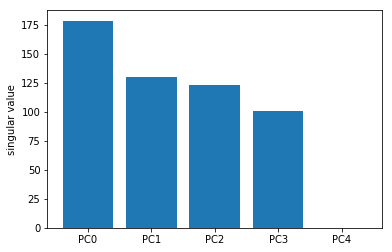

In [51]:
# make a bar chart of the singular values
plot_singular_values(pca.singular_values_)

The first four principal components have significant contributions. The last principal component has a negligible contribution.

In [52]:
# for the components,
# rows are components (transformed variables)
# columns are features (original variables)
pca.components_

array([[  2.57106232e-01,   3.23911722e-01,  -6.44374485e-01,
          6.42981692e-01,   1.82660667e-02],
       [ -6.82175472e-01,  -5.90820746e-01,  -3.01035657e-01,
          2.64222011e-01,   1.58529915e-01],
       [  1.27976342e-01,   6.66193859e-02,  -6.08256228e-02,
         -1.73313854e-01,   9.72340714e-01],
       [  6.72424767e-01,  -7.35917047e-01,  -4.74435304e-02,
          5.51901859e-02,  -3.12119800e-02],
       [  1.41725854e-15,  -1.97960802e-15,   6.98719122e-01,
          6.95469356e-01,   1.67672193e-01]])

In [53]:
def plot_principal_components(pc, var_names, n_comp=1):
    '''
    make a plot showing the variable loading for each pricinpal component
    Inputs:
        pc: square 2-d array of principal components. rows are components, columns are variables
        var_names: list of variable names
        n_comp: number of principal components to plot
    Return: none
    '''
    
    n_var = pc.shape[0]
    n_comp = min(n_comp, n_var) # in case n_comp is larger than the number of components
    
    width = 0.9 / n_var # width of each bar
    x0 = -(n_comp - 1) / 2 # offset of first component's bar from tick withing the group of bars for a variable
    x = np.arange(n_var)
    
    plt.figure(figsize=(15,5))
    for i in range(min(n_comp, n_var)):
        plt.bar(x + x0 * width, pc[i], width=width, label='PC'+str(i))
        x0 += 1
    plt.xticks(x, var_names)
    plt.legend();

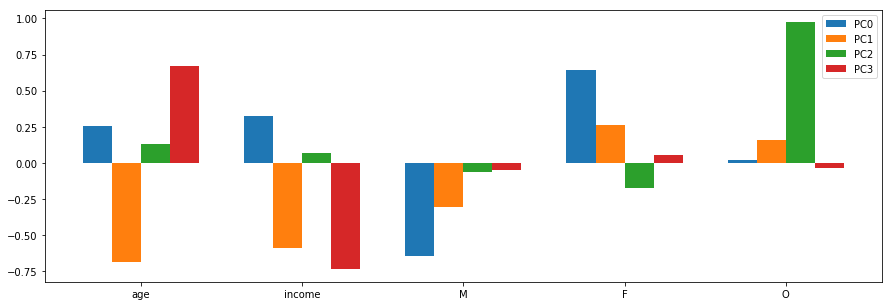

In [54]:
plot_principal_components(pca.components_, ['age','income','M','F','O'], 4)

PC0 (strongest tendency; blue bars): The largest blue bars make it clear that two genders exits - male and female. The other gender is not highlighted, perhaps because there are few customers who identified as other gender. To a smaller extent, the female gender is associated with slightly higher age and higher income whereas the male gender is associated with slightly lower age and lower income.

PC1 (next strongest tendency; orange bars): The largest orange bars show a positive correlation between age and gender. To a smaller extent, higher age and income is associated with the male gender and lower age and income with the female gender. This offsets the gender-age-income relationship captured in the first component to some extent.

PC2 (comparable strength to PC1; green bars): Captures the other gender, with a slight association with higher age and higher income.

PC3 (slightly weaker than PC2; red bars) Shows that having above-average age and below-average income (and vice versa) does not correlate with gender. That is individuals with above-average age and below-average income (and vice versa) could belong to any gender.

This scatter plot, based only on the first two principal components, shows that age and income go together; male and female are opposites; and other gender has a slight negative correlation with age and income.

In [55]:
colors = {'M':'blue', 'F':'red', 'O':'green'}

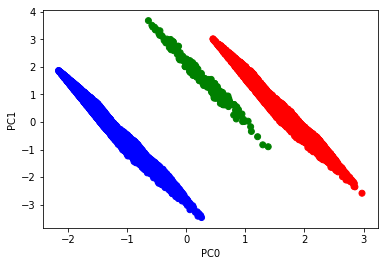

In [56]:
plt.scatter(scores[:,0], scores[:,1], c=df_profile_groups['gender'].map(colors))
plt.xlabel('PC0')
plt.ylabel('PC1');

This shows the high age/high income (at the lower right of the cluster) versus low age/low income (upper left of cluster) among the three genders (M=blue; F=red; O=green). This also shows the tendency of females to be higher age and higher income (red cluster is to the right of the blue cluster).

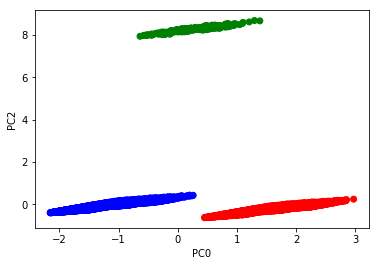

In [57]:
plt.scatter(scores[:,0], scores[:,2], c=df_profile_groups['gender'].map(colors))
plt.xlabel('PC0')
plt.ylabel('PC2');

This separates out the O gender (upper portion of chart) from the M and F genders.

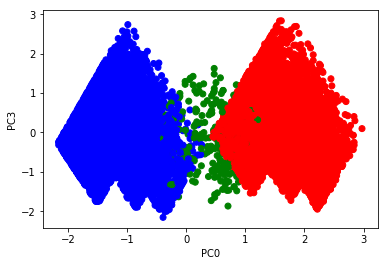

In [58]:
plt.scatter(scores[:,0], scores[:,3], c=df_profile_groups['gender'].map(colors))
plt.xlabel('PC0')
plt.ylabel('PC3');

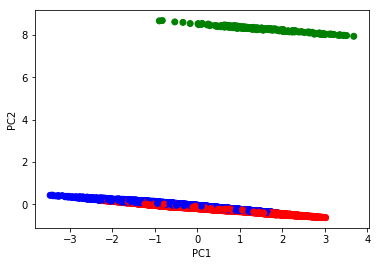

In [59]:
plt.scatter(scores[:,1], scores[:,2], c=df_profile_groups['gender'].map(colors))
plt.xlabel('PC1')
plt.ylabel('PC2');

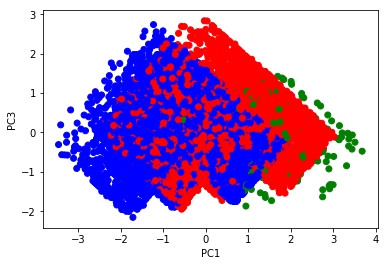

In [60]:
plt.scatter(scores[:,1], scores[:,3], c=df_profile_groups['gender'].map(colors))
plt.xlabel('PC1')
plt.ylabel('PC3');

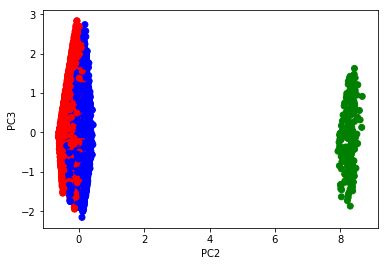

In [61]:
plt.scatter(scores[:,2], scores[:,3], c=df_profile_groups['gender'].map(colors))
plt.xlabel('PC2')
plt.ylabel('PC3');

In [62]:
var_names = ['age','income','M','F','O']

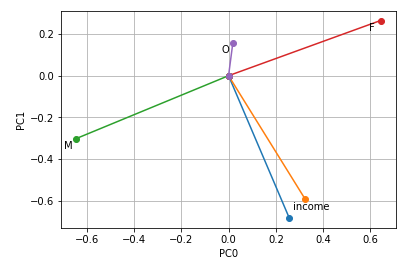

In [63]:
%matplotlib inline
for i in range(pca.components_[0].shape[0]):
    plt.plot([0,pca.components_[0][i]], [0,pca.components_[1][i]], '-o')

for i, txt in enumerate(var_names):
    plt.annotate(txt, (pca.components_[0][i]-0.05, pca.components_[1][i]-0.05))
    
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.grid();

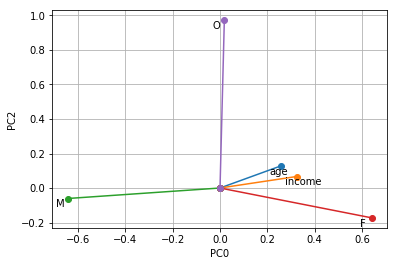

In [64]:
for i in range(pca.components_[0].shape[0]):
    plt.plot([0,pca.components_[0][i]], [0,pca.components_[2][i]], '-o')

for i, txt in enumerate(var_names):
    plt.annotate(txt, (pca.components_[0][i]-0.05, pca.components_[2][i]-0.05))
    
plt.xlabel('PC0')
plt.ylabel('PC2')
plt.grid();

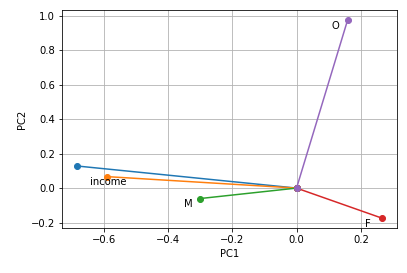

In [65]:
for i in range(pca.components_[1].shape[0]):
    plt.plot([0,pca.components_[1][i]], [0,pca.components_[2][i]], '-o')

for i, txt in enumerate(var_names):
    plt.annotate(txt, (pca.components_[1][i]-0.05, pca.components_[2][i]-0.05))
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid();

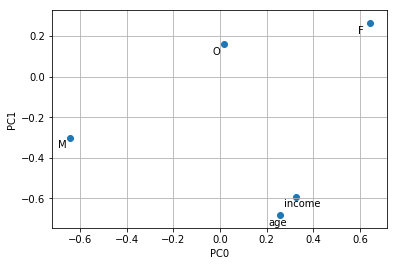

In [66]:
plt.scatter(pca.components_[0], pca.components_[1])
for i, txt in enumerate(var_names):
    plt.annotate(txt, (pca.components_[0][i]-0.05, pca.components_[1][i]-0.05))
    
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.grid();

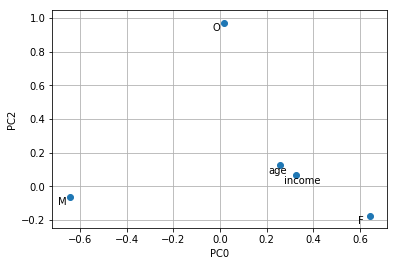

In [67]:
plt.scatter(pca.components_[0], pca.components_[2])

for i, txt in enumerate(var_names):
    plt.annotate(txt, (pca.components_[0][i]-0.05, pca.components_[2][i]-0.05))
    
plt.xlabel('PC0')
plt.ylabel('PC2')
plt.grid();

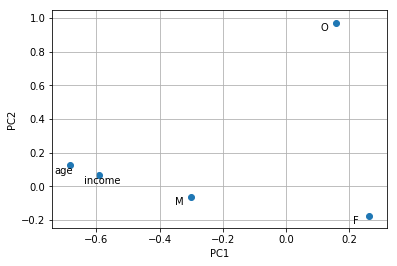

In [68]:
plt.scatter(pca.components_[1], pca.components_[2])
var_names = ['age','income','M','F','O']
for i, txt in enumerate(var_names):
    plt.annotate(txt, (pca.components_[1][i]-0.05, pca.components_[2][i]-0.05))
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid();

<IPython.core.display.Javascript object>


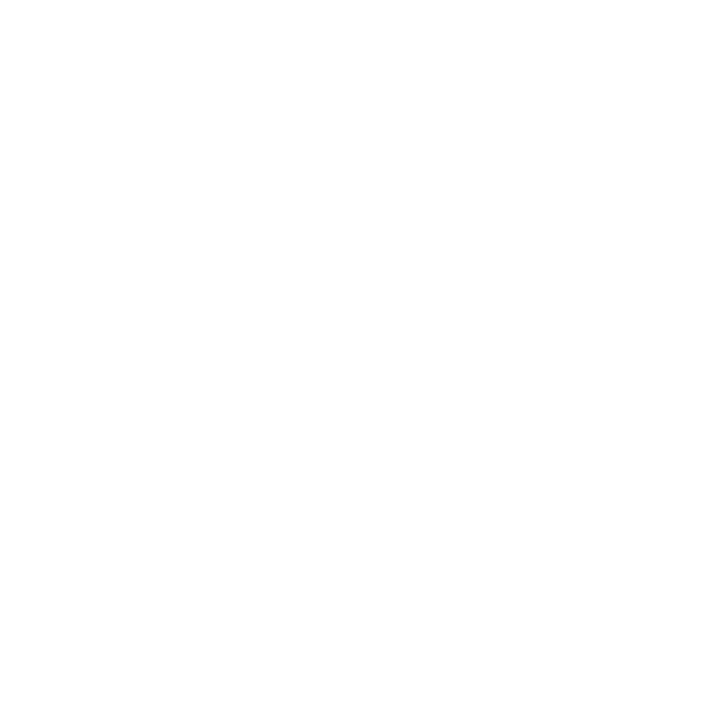

<IPython.core.display.Javascript object>


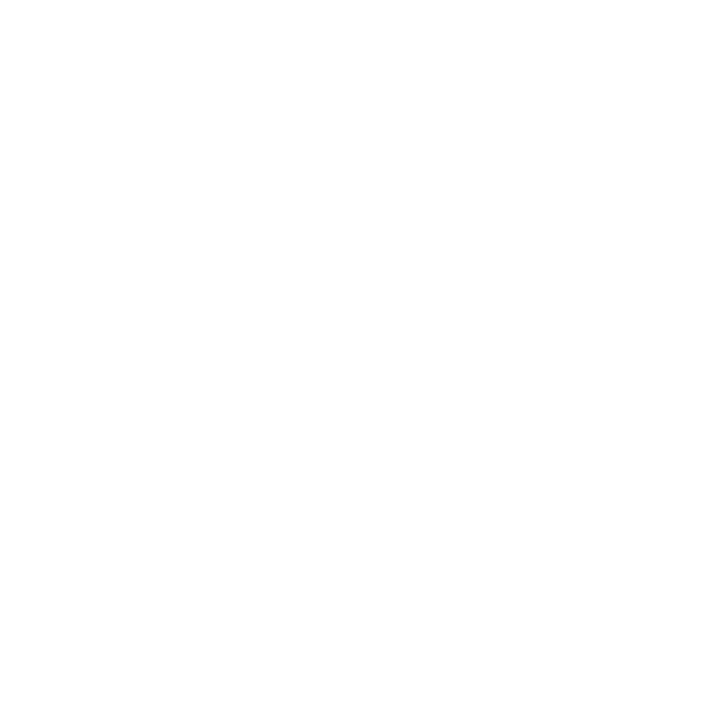

In [69]:
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
    
ax = fig.add_subplot(111, projection='3d')
for i, txt in enumerate(var_names):
    ax.plot([0, pca.components_[0][i]], [0, pca.components_[1][i]], [0, pca.components_[2][i]], '-o')
    ax.text(pca.components_[0][i]-0.05, pca.components_[1][i]-0.05, pca.components_[2][i]-0.05, txt)



### The above 3d scatter plot sometimes does not work in the notebook.

Rotating the above scatter plots and 3d plot shows that in the first three components:
1. Age and income are together, implying high positive correlation between the two;
2. M and F genders are opposite to each other (can be one or the other);
3. O gender is orthogonal to M and F (if there were more customers of O gender, the three would have formed an equilateral triangle, I think);
4. Age and income are on a line that is perpendicular to the plane formed by M, F and O, which means that age and income are largely unrelated to gender.

In [70]:
# reset
%matplotlib inline

### Try K-Means clustering to see if it provides any additional insight.

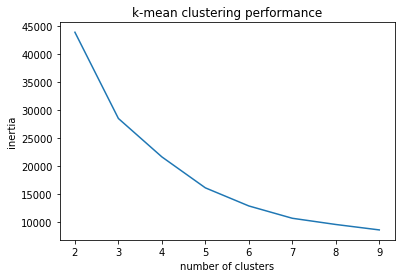

In [71]:
# try the KMeans algorithm for different numbers of clusters
# X_scaled is available from the PCA analysis

km_results = []

for n_clusters in range(2,10):
    km = KMeans(n_clusters=n_clusters, random_state=99)
    km.fit(X_scaled)
    km_transform = km.transform(X_scaled)
    inertia = km.inertia_
    km_results.append([n_clusters, inertia, km.cluster_centers_])

km_results = pd.DataFrame(km_results)
%matplotlib inline
plt.plot(km_results[0], km_results[1])
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.title('k-mean clustering performance');

The performance improves as the number of clusters increases. There is no distict "elbow" in the above plot. Let us examine how the clusters are centered. Keep in mind that the variables are in the following order: age, income, M, F, O.

With two clusters, as seen below, the first cluster is for M gender and the second cluster if for F gender. The M cluster center has lower age and income than the F cluster center.

In [72]:
# cluster centers using two clusters
km_results.iloc[0][2]

array([[-0.13097961, -0.19494738,  0.86452697, -0.83952773, -0.12044762],
       [ 0.17524539,  0.26083167, -1.15670191,  1.12325394,  0.16115402]])

With three clusters (see cell below), the clusters are centered as follows:
1. F gender, above average age and income;
2. M gender, below average age and income;
3. O gender, average age and income.

In [73]:
# cluster centers using three clusters
km_results.iloc[1][2]

array([[  1.81292309e-01,   2.73244643e-01,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01],
       [ -1.30979613e-01,  -1.94947384e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01],
       [  4.26790167e-04,  -9.80321224e-02,  -1.15670191e+00,
         -8.39527729e-01,   8.30236384e+00]])

With four clusters (see cell below), the clusters are centered as follows:
1. M gender, above-average age and income;
2. F gender, above-average age and income;
3. O gender, average age and income;
4. M gender, below average age and income.

In [74]:
# cluster centers using four clusters
km_results.iloc[2][2]

array([[  5.67397045e-01,   2.80657137e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01],
       [  1.81292309e-01,   2.73244643e-01,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01],
       [  4.26790167e-04,  -9.80321224e-02,  -1.15670191e+00,
         -8.39527729e-01,   8.30236384e+00],
       [ -9.22801035e-01,  -7.34189130e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01]])

With five clusters (see cell below), the clusters are centered as follows:
1. F gender, above average age and income;
2. M gender, below average age and income;
3. F gender, below average age and income;
4. M gender, above average age and income;
5. O gender, average age and income.

In [75]:
# cluster centers using five clusters
km_results.iloc[3][2]

array([[  6.73576146e-01,   9.95043465e-01,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01],
       [ -9.36118498e-01,  -7.33232217e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01],
       [ -4.00928000e-01,  -5.80421270e-01,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01],
       [  5.63837211e-01,   2.69580370e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01],
       [  4.26790167e-04,  -9.80321224e-02,  -1.15670191e+00,
         -8.39527729e-01,   8.30236384e+00]])

As more clusters are added (for example, see the cell below for six clusters), the clusters remain differentiated primarily by gender, with differentiation by age and income becoming more granular.

In [76]:
# cluster centers using six clusters
km_results.iloc[4][2]

array([[ -1.17664354e+00,  -6.50850576e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01],
       [  6.73746618e-01,   9.91112969e-01,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01],
       [  5.87795998e-01,  -7.18366591e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01],
       [  3.71766429e-01,   9.14357648e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01],
       [  4.26790167e-04,  -9.80321224e-02,  -1.15670191e+00,
         -8.39527729e-01,   8.30236384e+00],
       [ -4.05356873e-01,  -5.81934929e-01,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01]])

### Conclusion of clustering analysis:
PCA and K-Means are in agreement. Gender is the primary point of differentiation. Over all, M-gender has below-average age and income while F-gender has above average age and income. O-gender age and income are at the average for the datat set.

K-Means is able to create finer distinctions. These are around creating sub-groups within the three genders base on age and income.

We will pause the clustering analysis here, but it pick up later to see whether there are any relationships between clusters and customer behavior.

## Examine transcript data frame

In [77]:
transcript.shape

(306534, 4)

In [78]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [79]:
# how many missing items in each column?
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

There are no missing entries in this data set.

In [80]:
# how many types of events are there?
print('there are {} possible values for event'.format(transcript['event'].nunique()))
print('the possible values for event are {}'.format(transcript['event'].unique().tolist()))

there are 4 possible values for event
the possible values for event are ['offer received', 'offer viewed', 'transaction', 'offer completed']


In [81]:
# get statistics for the time column (time is in hours)
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

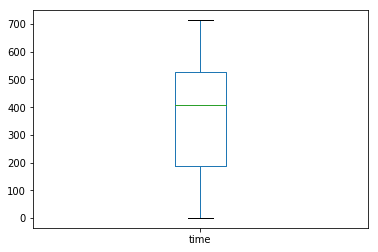

In [82]:
# visualize time distribution as a box plot
transcript.boxplot(column='time', grid=False);

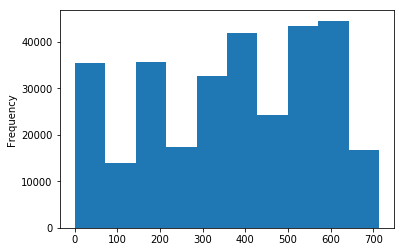

In [83]:
# visualize time distribution as a histogram
transcript['time'].plot.hist();

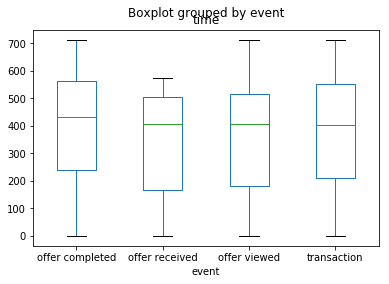

In [84]:
# view time statistics for each type of event
transcript.boxplot(by='event', column='time', grid=False);

In [85]:
# how many persons?
print('the number of unique persons in the transcript data set is {}'.format(transcript['person'].nunique()))
print('the number of unique persons in the profile data set is {}'.format(profile['id'].nunique()))

the number of unique persons in the transcript data set is 17000
the number of unique persons in the profile data set is 17000


In [86]:
# are the persons (ids) the same in both profile and transcripts data sets?
assert set(profile['id']) == set(transcript['person']), 'the ids are NOT the same in the two data sets'
print('the ids in the two data sets are the same')

the ids in the two data sets are the same


The number of persons in the profile and transcript data sets is the same.

In [87]:
# how many events for each person?
transcript.groupby('person')['event'].count().describe()

count    17000.000000
mean        18.031412
std          6.849595
min          1.000000
25%         13.000000
50%         17.000000
75%         23.000000
max         51.000000
Name: event, dtype: float64

Some persons had only one event. Some had as many as fifty one events. Half the persons (25th to 75th percentile) had between thirteen and twenty three events.

In [88]:
# how many offers did each person receive?
transcript[transcript['event'] == 'offer received'].groupby('person')['event'].count().describe()

count    16994.000000
mean         4.488467
std          1.073047
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          6.000000
Name: event, dtype: float64

Everyone received at least one offer. Most persons received at least five offers. Some received as many as six offers.

In [89]:
np.sort(transcript[transcript['event'] == 'offer received'].groupby('person')['event'].count().unique())

array([1, 2, 3, 4, 5, 6])

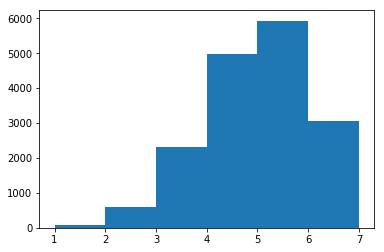

In [90]:
plt.hist(transcript[transcript['event'] == 'offer received'].groupby('person')['event'].count(), bins=range(1,8));

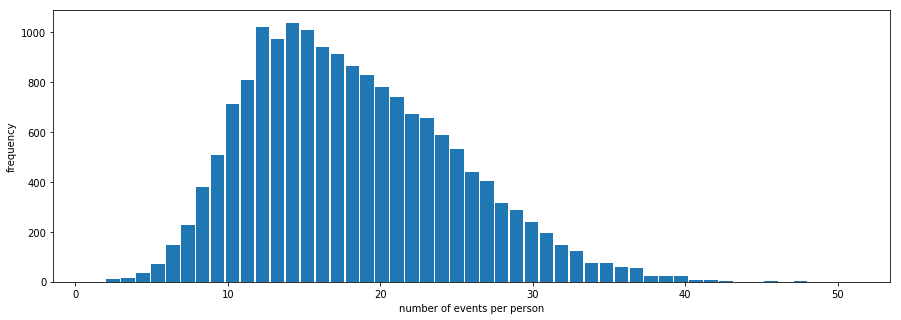

In [91]:
# plot a histogram of number of events per person
plt.figure(figsize=(15,5))
transcript.groupby('person')['event'].count().hist(grid=False, bins=51, rwidth=0.9)
plt.xlabel('number of events per person')
plt.ylabel('frequency');

In [92]:
# pick an arbitrary person. what is the event history? sort by time earlies to latest.
# change the index of the unique series to select a different person
transcript[transcript['person'] == transcript['person'].unique()[0]].sort_values('time')

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [93]:
# look at all the dicts in the value column and make a list of all possible keys
key_list = set()
for value in transcript['value']:
    key_list.update(value.keys())

key_list = list(key_list)
print('the keys are {}'.format(key_list))

the keys are ['offer_id', 'offer id', 'reward', 'amount']


Is the 'offer_id' key the same as the 'offer id' key? Let's look at a few dicts, some with 'offer_id' and some with 'offer id'.

In [94]:
transcript.loc[0]['value']

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

In [95]:
transcript.loc[15561]['value']

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

In [96]:
transcript.loc[163375]['value']

{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}

In [97]:
transcript.loc[201572]['value']

{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}

The above dicts have a 'offer id' key. It is the only key/value pair in the dict.

In [98]:
transcript.loc[47583]['value']

{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}

In [99]:
transcript.loc[218394]['value']

{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}

In [100]:
transcript.loc[218395]['value']

{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}

The above dicts have a 'offer_id' key and also another key/value. The second key is 'reward'.

In [101]:
# Add the following columns to the transcript data frame:
# 'offer_id' - contains the offer id or offer_id if there is one, else na;
# 'amount' - contains the amount if there is an amount, else na;
# 'reward' - contains the reward if there is one, else na;



def get_offer_id(row):
    '''
    extracts the value corresponding to the 'offer_id' or 'offer id' key in the input dictionary
    in the 'value' column of the input row
    Input:
        row: a row of the transcript dataframe
    Output:
        value for 'offer id' or 'offer_id' key as str, if there is such a key, np.nan otherwise
    '''
    d = row['value']
    if 'offer id' in d:
        return str(d['offer id'])
    elif 'offer_id' in d:
        return str(d['offer_id'])
    else:
        return np.nan
    
def get_amount(row):
    '''
    extracts the value corresponding to the 'amount' key in the input dictionary in the 'value' column
    of the input row
    Input:
        row: a row of the transcript dataframe
    Output:
        value for 'amount' key, if there is such a key, np.nan otherwise
    '''
    d = row['value']
    if 'amount' in d:
        return d['amount']
    else:
        return np.nan
        
def get_reward(row):
    '''
    extracts the value corresponding to the 'amount' key in the input dictionary in the 'value' column
    of the input row
    Input:
        row: a row of the transcript dataframe
    Output:
        value for 'reward' key, if there is such a key, np.nan otherwise
    '''
    d = row['value']
    if 'reward' in d:
        return d['reward']
    else:
        return np.nan
    
transcript['id'] = transcript.apply(get_offer_id, axis=1)
transcript['amount'] = transcript.apply(get_amount, axis=1)
transcript['reward'] = transcript.apply(get_reward, axis=1)

In [102]:
transcript.head()

,event,person,time,value,id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


Check some stats on how many of each offer were received, viewed and completed

In [103]:
transcript.groupby(['id','event'])['event'].count()

id                                event          
0b1e1539f2cc45b7b9fa7c272da2e1d7  offer completed    3420
                                  offer received     7668
                                  offer viewed       2663
2298d6c36e964ae4a3e7e9706d1fb8c2  offer completed    5156
                                  offer received     7646
                                  offer viewed       7337
2906b810c7d4411798c6938adc9daaa5  offer completed    4017
                                  offer received     7632
                                  offer viewed       4118
3f207df678b143eea3cee63160fa8bed  offer received     7617
                                  offer viewed       4144
4d5c57ea9a6940dd891ad53e9dbe8da0  offer completed    3331
                                  offer received     7593
                                  offer viewed       7298
5a8bc65990b245e5a138643cd4eb9837  offer received     7618
                                  offer viewed       6687
9b98b8c7a33c4b65b9aebf

In [104]:
# check if the values in the 'offer_id' column of transcript are the same as the values in the 'id' column of portfolio.
# first, remove the nan (if any) from the set of values in the 'offer_id' column in transcript. there probably will be nan
# in the set from the 'reward' and 'amount' keys in the 'value' column.

# create a set of the values in the 'offer_id' column in transcript
s = set(transcript['id'].unique())
# remove nan exploiting that in python nan != nan
{e for e in s if e  == e}

assert {e for e in s if e  == e} == set(portfolio['id'].unique()), 'They are DIFFERENT'
print('They are the SAME.')

They are the SAME.


In [105]:
# the value column is not needed any more, as its information is contained in the offer_id, amount and reward columns
transcript.drop(columns=['value'], inplace=True)

In [106]:
# pick an arbitrary person. what is the event history? sort by time earlies to latest.
# change the index of the unique series to select a different person
transcript[transcript['person'] == transcript['person'].unique()[0]].sort_values('time')

,event,person,time,id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,19.89,NaN
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,NaN,17.78,NaN
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,NaN,19.67,NaN
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,NaN,29.72,NaN
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,NaN,23.93,NaN


In [107]:
transcript.groupby(['event','id'])['time'].max()

event            id                              
offer completed  0b1e1539f2cc45b7b9fa7c272da2e1d7    714
                 2298d6c36e964ae4a3e7e9706d1fb8c2    714
                 2906b810c7d4411798c6938adc9daaa5    714
                 4d5c57ea9a6940dd891ad53e9dbe8da0    696
                 9b98b8c7a33c4b65b9aebfe6a799e6d9    714
                 ae264e3637204a6fb9bb56bc8210ddfd    714
                 f19421c1d4aa40978ebb69ca19b0e20d    696
                 fafdcd668e3743c1bb461111dcafc2a4    714
offer received   0b1e1539f2cc45b7b9fa7c272da2e1d7    576
                 2298d6c36e964ae4a3e7e9706d1fb8c2    576
                 2906b810c7d4411798c6938adc9daaa5    576
                 3f207df678b143eea3cee63160fa8bed    576
                 4d5c57ea9a6940dd891ad53e9dbe8da0    576
                 5a8bc65990b245e5a138643cd4eb9837    576
                 9b98b8c7a33c4b65b9aebfe6a799e6d9    576
                 ae264e3637204a6fb9bb56bc8210ddfd    576
                 f19421c1d4aa40978ebb6

In [108]:
transcript[(transcript['id'] == '2298d6c36e964ae4a3e7e9706d1fb8c2') & (transcript['event'] == 'offer received')]['time'].unique()

array([  0, 168, 336, 408, 504, 576])

In [109]:
for id in transcript['id'].unique():
    for event in transcript['event'].unique():
        print('offer: {} event: {} timing: {}'.format(id, event, transcript[(transcript['id'] == id) & (transcript['event'] == event)]['time'].unique()))

offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9 event: offer received timing: [  0 168 336 408 504 576]
offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9 event: offer viewed timing: [  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 600 606 612 618 624 630 636 642
 648 654 660 666 672 678 684 690 696 702 708 714]
offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9 event: transaction timing: []
offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9 event: offer completed timing: [  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 

In [110]:
transcript[transcript['id'] == 'fafdcd668e3743c1bb461111dcafc2a4'].sort_values(['person','time']).head(100)

,event,person,time,id,amount,reward
204340,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
228423,offer completed,0009655768c64bdeb2e877511632db8f,528,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0
233413,offer viewed,0009655768c64bdeb2e877511632db8f,540,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
1889,offer received,0020c2b971eb4e9188eac86d93036a77,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
18431,offer viewed,0020c2b971eb4e9188eac86d93036a77,12,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
31327,offer completed,0020c2b971eb4e9188eac86d93036a77,54,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0
112698,offer received,0020c2b971eb4e9188eac86d93036a77,336,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
218936,offer completed,0020c2b971eb4e9188eac86d93036a77,510,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0
55857,offer received,003d66b6608740288d6cc97a6903f4f0,168,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
105508,offer viewed,003d66b6608740288d6cc97a6903f4f0,300,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN


In [111]:
# check offer received times for each of the offers
for id in transcript['id'].unique():
    print('id: {} received timing: {}'.format(id, transcript[(transcript['id'] == id) & (transcript['event'] == 'offer received')]['time'].unique()))

id: 9b98b8c7a33c4b65b9aebfe6a799e6d9 received timing: [  0 168 336 408 504 576]
id: 0b1e1539f2cc45b7b9fa7c272da2e1d7 received timing: [  0 168 336 408 504 576]
id: 2906b810c7d4411798c6938adc9daaa5 received timing: [  0 168 336 408 504 576]
id: fafdcd668e3743c1bb461111dcafc2a4 received timing: [  0 168 336 408 504 576]
id: 4d5c57ea9a6940dd891ad53e9dbe8da0 received timing: [  0 168 336 408 504 576]
id: f19421c1d4aa40978ebb69ca19b0e20d received timing: [  0 168 336 408 504 576]
id: 2298d6c36e964ae4a3e7e9706d1fb8c2 received timing: [  0 168 336 408 504 576]
id: 3f207df678b143eea3cee63160fa8bed received timing: [  0 168 336 408 504 576]
id: ae264e3637204a6fb9bb56bc8210ddfd received timing: [  0 168 336 408 504 576]
id: 5a8bc65990b245e5a138643cd4eb9837 received timing: [  0 168 336 408 504 576]
id: nan received timing: []


The different types of offers were all received at the same times. The nan id in the transcript data frame corresponds to transactions.

In [112]:
# calculate expiration times for each of the offers. duration in the portfolio data frame is in days.
for id in transcript['id'].unique():
    print('offer: {} expiration timing: {}'.format(id, transcript[(transcript['id'] == id) & (transcript['event'] == 'offer received')]['time'].unique() + portfolio[portfolio['id'] == id]['duration'].values * 24))

offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9 expiration timing: [168 336 504 576 672 744]
offer: 0b1e1539f2cc45b7b9fa7c272da2e1d7 expiration timing: [240 408 576 648 744 816]
offer: 2906b810c7d4411798c6938adc9daaa5 expiration timing: [168 336 504 576 672 744]
offer: fafdcd668e3743c1bb461111dcafc2a4 expiration timing: [240 408 576 648 744 816]
offer: 4d5c57ea9a6940dd891ad53e9dbe8da0 expiration timing: [120 288 456 528 624 696]
offer: f19421c1d4aa40978ebb69ca19b0e20d expiration timing: [120 288 456 528 624 696]
offer: 2298d6c36e964ae4a3e7e9706d1fb8c2 expiration timing: [168 336 504 576 672 744]
offer: 3f207df678b143eea3cee63160fa8bed expiration timing: [ 96 264 432 504 600 672]
offer: ae264e3637204a6fb9bb56bc8210ddfd expiration timing: [168 336 504 576 672 744]
offer: 5a8bc65990b245e5a138643cd4eb9837 expiration timing: [ 72 240 408 480 576 648]
offer: nan expiration timing: []


The last expiration time for any offer was t=816. Since the last time stamp in the event log is t=714, it means that some offers were still open when the test event logging ended.

Completed offers can be counted as successful offers.

Offers that expired before or at end of the test (t=714) without being completed can be counted as unsuccessful offers.

Offers that were not completed but had not yet expired at the end of the test must be counted as inconclusive.

In [113]:
# out of curiosity,  check offer received times for each of the offers
for id in transcript['id'].unique():
    print('id: {} viewed timing: {}'.format(id, transcript[(transcript['id'] == id) & (transcript['event'] == 'offer viewed')]['time'].unique()))

id: 9b98b8c7a33c4b65b9aebfe6a799e6d9 viewed timing: [  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 600 606 612 618 624 630 636 642
 648 654 660 666 672 678 684 690 696 702 708 714]
id: 0b1e1539f2cc45b7b9fa7c272da2e1d7 viewed timing: [  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 60

Nothing to note, as far as I can tell.

In [114]:
# out of curiosity,  check offer completed times for each of the offers
for id in transcript['id'].unique():
    print('id: {} viewed timing: {}'.format(id, transcript[(transcript['id'] == id) & (transcript['event'] == 'offer completed')]['time'].unique()))

id: 9b98b8c7a33c4b65b9aebfe6a799e6d9 viewed timing: [  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 600 606 612 618 624 630 636 642
 648 654 660 666 672 678 684 690 696 702 708 714]
id: 0b1e1539f2cc45b7b9fa7c272da2e1d7 viewed timing: [  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 60

Nothing to note, as far as I can tell.

Events appear to be logged with a batch time of six hours, it appears. I don't think this is important.

### Since some offers had not expired at the end of the event log, detailed accounting is needed to categorize each offer to each person as successful, unsuccessful or inconclusive.

This is done by the following:

# SIMULATION

The next step is to categorize the outcome of each offer received by each person. The categories are as follows:
1. Successful: person received, viewed and completed the offer before it expired;
2. Unsuccessful: person received and viewed the offer. The expiry was within the test period, but the person did not complete the offer before it expired;
3. Inconclusive: person received and viewed the offer. The expiry was after the end of the test period. The person did not complete the offer before the test period ended, but had time to complete it after the test period ended;
4. Unsolicited: a transaction made without viewing an offer;
5. Lost: person received the offer but did not view it or make a purchase.

In [115]:
# the following are functions used to process each event and organize the information related to the event

def mark_expireds(df, t):
    '''
    each offer that
    1. has an expiry before t and
    2. has not been marked as expired and
    3. has not been completed by time t
    is marked as expired

    Input:
        df: data frame with offers. the data frame should be sorted by time and event (received before viewed before completed before transaction).
        t: time
    
    Output:
        df: updated offer info data frame
    '''
    idx = df[(df['expired'].isna()) & (df['expires'] < t) & (df['completed'].isna())].index
    df.at[idx,'expired'] = t
    return df

def process_received(row, df):
    '''
    organizes the information in a single 'offer received' event
    
    Input:
        row: data frame with information about a single 'offer received' event
        df: data frame with offer.  the data frame should be sorted by time and event (received before viewed before completed before transaction).
    
    Output:
        df: updated offer info data frame
    '''
    # mark expired offers
    df = mark_expireds(df, row['time'])
    # add new offer
    df = df.append({'person': row['person'], 'id': row['id'], 'received': row['time'], 'expires': row['time'] + 24 * portfolio[portfolio['id'] == row['id']]['duration'].values[0]}, ignore_index=True)
    return df

def process_viewed(row, df):
    '''
    organizes the information in a single 'offer viewed' event
    
    Input:
        row: data frame with information about a single 'offer viewed' event
        df: data frame with offer.  the data frame should be sorted by time and event (received before viewed before completed before transaction).
    
    Output:
        df: updated offer info data frame
    '''
    # mark expired offers
    df = mark_expireds(df, row['time'])
    # find earliest non-viewed offer with this id and fill in the 'viewed' column
    idx = df[(df['id'] == row['id']) & (df['viewed'].isna())].sort_values('received').head(1).index
    df.at[idx,'viewed'] = row['time']
    return df

def process_completed(row, df):
    '''
    organizes the information in a single 'offer completed' event
    
    Input:
        row: data frame with information about a single 'offer completed' event
        df: data frame with offer.  the data frame should be sorted by time and event (received before viewed before completed before transaction).
    
    Output:
        df: updated offer info data frame
    '''
    # mark expired offers
    df = mark_expireds(df, row['time'])
    # find earliest non-completed unexpired offer with this id and fill in the 'completed' column
    idx = df[(df['id'] == row['id']) & (df['completed'].isna()) & (df['expired'].isna())].sort_values('received').head(1).index
    df.at[idx,'completed'] = row['time']
    return df

def process_transaction(row, df):
    '''
    organizes the information in a single 'transaction' event
    
    Input:
        row: data frame with information about a single 'transaction' event
        df: data frame with offer.  the data frame should be sorted by time and event (received before viewed before completed before transaction).
    
    Output:
        df: updated offer info data frame
    '''
    # mark expired offers
    df = mark_expireds(df, row['time'])
    # if a transaction occurs when one/more viewed but uncompleted offers exist, it counts toward one of those offers
    # if a transaction occurs at the same time as a completed offer, it is assumed to correspond to that completed offer
    # if a transaction occurs when no viewed but uncompleted offer exists, it counts as an unsolicited transaction
    # this works before transactions are at the end of the sort
    ct = df[ \
             (~df['viewed'].isna()) & \
             (df['viewed'] <= row['time']) & \
             (df['expired'].isna()) & \
             ((df['completed'].isna()) | (df['completed'] != row['time'])) \
            ]['id'].count()
    if ct > 0:
        # unsolicited transaction. add to df and mark accordingly.
        df = df.append({'person': row['person'], 'id': 'unsolicited transaction', 'received': row['time']}, ignore_index=True)
    return df


In [116]:
# at a given time, we want to sort events in the following order: received, viewed, completed, transaction. 
# this is required to use the above functions.

# add a column to the transcript data frame with this this ordering
if ~('event order' in transcript.columns):
    transcript['event order'] = np.nan
transcript['event order'] = transcript['event'].apply(lambda x: 0 if x == 'offer received' else (1 if x == 'offer viewed' else (2 if x == 'offer completed' else 4)))


In [117]:
# time at which transcript ends
t_end = transcript['time'].max()

In [118]:
# for each person, place each offer into one of five categories: successful, unsuccessful, inconclusive, unsolicited, lost.
# use progress bar. this step will take a while.

def organize_offers(read_saved_person_offer=True):
    '''
    examines each offer and transaction for each person and organizes the time for received, viewed, completed and expired
    Input:
        read_saved_person_offer: (bool) if True, organized information is read from a previously-saved pickle file.
            if False, the organization is recalculated (can take as much as an hour or more)
    Output:
        data frame containing the person/offer/transaction in a better organized format
    '''
    if read_saved_person_offer:
        # read saved data frame
        df_all_person_offer = pd.read_pickle('./df_all_person_offer.pkl')        
    else:
        df_all_person_offer = pd.DataFrame()
        for person in tqdm(transcript['person'].unique()):
            # data frame for this person
            df_person_offer = pd.DataFrame(columns=['person', 'id', 'received', 'expires', 'viewed', 'completed', 'expired'])
            # sort events as needed by the functions
            df = transcript[transcript['person'] == person].sort_values(['time','event order'])
            for idx in df.index:
                if df.loc[idx]['event'] == 'offer received':
                    df_person_offer = process_received(df.loc[idx], df_person_offer)
                if df.loc[idx]['event'] == 'offer viewed':
                    df_person_offer = process_viewed(df.loc[idx], df_person_offer)
                if df.loc[idx]['event'] == 'offer completed':
                    df_person_offer = process_completed(df.loc[idx], df_person_offer)
                if df.loc[idx]['event'] == 'transaction':
                    df_person_offer = process_transaction(df.loc[idx], df_person_offer)
            
            # cleanup - see if any offfers expired at the end of the transcript
            df_person_offer = mark_expireds(df_person_offer, t_end)
    
            df_all_person_offer = df_all_person_offer.append(df_person_offer, ignore_index=True)
        
        # save the data frame
        df_all_person_offer.to_pickle('./df_all_person_offer.pkl')            
        
    return df_all_person_offer
        

In [119]:
df_all_person_offer = organize_offers(read_saved_person_offer)

In [120]:
# mark whether or not each offer is successful
def is_successful(id, t_viewed, t_completed):
    '''
    determine whether or not an offer or transaction is successful
    
    Inputs:
        id: (str) id of offer or transaction
        t_viewed: (int) time at which offer was received
        t_completed: (int) time at which offer was completed
        
    Output:
        1 if offer was successful, 0 otherwise
    '''
    if id == 'unsolicited transaction':
        return 0
    elif np.isnan(t_viewed):
        return 0
    elif np.isnan(t_completed):
        return 0
    elif t_viewed > t_completed:
        return 0
    else:
        return 1

df_all_person_offer['successful'] = df_all_person_offer.apply(lambda x: is_successful(x['id'], x['viewed'], x['completed']), axis=1)

In [121]:
# mark whether or not each offer is unsuccessful
def is_unsuccessful(id, t_viewed, t_expired):
    '''
    determine whether or not an offer or transaction is unsuccessful
    
    Inputs:
        id: (str) id of offer or transaction
        t_viewed: (int) time at which offer was received
        t_expired: (int) time at which offer expired
        
    Output:
        1 if offer was unsuccessful, 0 otherwise
    '''
    if id == 'unsolicited transaction':
        return 0
    elif np.isnan(t_viewed):
        return 0
    elif ~np.isnan(t_expired):
        return 1
    else:
        return 0

df_all_person_offer['unsuccessful'] = df_all_person_offer.apply(lambda x: is_unsuccessful(x['id'], x['viewed'], x['expired']), axis=1)

In [122]:
# mark whether or not each offer is unsolicited
def is_unsolicited(id, t_viewed, t_completed):
    '''
    determine whether or not an offer or transaction is unsolicited
    
    Inputs:
        id: (str) id of offer or transaction
        t_viewed: (int) time at which offer was received
        t_completed: (int) time at which offer was completed
        
    Output:
        1 if offer was unsolicited, 0 otherwise
    '''
    if id == 'unsolicited transaction':
        return 1
    elif np.isnan(t_viewed) & ~np.isnan(t_completed):
        return 1
    elif ~np.isnan(t_viewed) & ~np.isnan(t_completed) & (t_viewed > t_completed):
        return 1
    else:
        return 0

df_all_person_offer['unsolicited'] = df_all_person_offer.apply(lambda x: is_unsolicited(x['id'], x['viewed'], x['completed']), axis=1)

In [123]:
# mark whether or not each offer is inconclusive
def is_inconclusive(id, t_viewed, t_completed, t_expired):
    '''
    determine whether or not an offer or transaction is inconclusive
    
    Inputs:
        id: (str) id of offer or transaction
        t_viewed: (int) time at which offer was received
        t_completed: (int) time at which offer was completed
        t_expired: (int) time at which offer expired
        
    Output:
        1 if offer was inconclusive, 0 otherwise
    '''
    if id == 'unsolicited transaction':
        return 0
    if np.isnan(t_viewed):
        return 0
    if ~np.isnan(t_completed):
        return 0
    if np.isnan(t_expired):
        return 1
    else:
        return 0

df_all_person_offer['inconclusive'] = df_all_person_offer.apply(lambda x: is_inconclusive(x['id'], x['viewed'], x['completed'], x['expired']), axis=1)

In [124]:
# mark whether or not each offer is lost
def is_lost(id, t_viewed, unsolicited):
    '''
    determine whether or not an offer or transaction is lost
    
    Inputs:
        id: (str) id of offer or transaction
        t_viewed: (int) time at which offer was received
        unsolicited: (int) 1 if offer was unsolicited, 0 otherwise
        
    Output:
        1 if offer was lost, 0 otherwise
    '''
    if id == 'unsolicited transaction':
        return 0
    if ~np.isnan(t_viewed):
        return 0
    if unsolicited == 1:
        return 0
    else:
        return 1

df_all_person_offer['lost'] = df_all_person_offer.apply(lambda x: is_lost(x['id'], x['viewed'], x['unsolicited']), axis=1)

In [125]:
# QC the results: check that one and only one of the following columns contains 1
stats = (df_all_person_offer['successful'] + df_all_person_offer['unsuccessful'] + df_all_person_offer['inconclusive'] + df_all_person_offer['unsolicited'] + df_all_person_offer['lost']).describe()
assert stats['min'] == 1, 'some offers are undercategorized'
assert stats['max'] == 1, 'some offers are overcategorized'
print('categorization appears ok')

categorization appears ok


In [126]:
# QC the results: the number of offers received must equal the sum of the number of offers in each of the 'successful',
# 'unsuccessful', 'inconclusive', 'unsolicited' and 'lost' categories
for offer in portfolio['id'].unique():
    n_received = transcript[(transcript['id'] == offer) & (transcript['event'] == 'offer received') & (transcript['person'].isin(df_all_person_offer['person'].unique()))]['id'].count()
    n_completed = transcript[(transcript['id'] == offer) & (transcript['event'] == 'offer completed') & (transcript['person'].isin(df_all_person_offer['person'].unique()))]['id'].count()
    n_successful = df_all_person_offer[(df_all_person_offer['id'] == offer) & (df_all_person_offer['successful'] == 1)]['id'].count()
    n_unsuccessful = df_all_person_offer[(df_all_person_offer['id'] == offer) & (df_all_person_offer['unsuccessful'] == 1)]['id'].count()
    n_inconclusive = df_all_person_offer[(df_all_person_offer['id'] == offer) & (df_all_person_offer['inconclusive'] == 1)]['id'].count()
    n_unsolicited = df_all_person_offer[(df_all_person_offer['id'] == offer) & (df_all_person_offer['unsolicited'] == 1)]['id'].count()
    n_lost = df_all_person_offer[(df_all_person_offer['id'] == offer) & (df_all_person_offer['lost'] == 1)]['id'].count()
    n_outcomes = n_successful + n_unsuccessful + n_inconclusive + n_unsolicited + n_lost
    assert n_received == n_outcomes, 'offer: {} ERROR n_received != n_outcomes'.format(offer)
    print('offer: {} n_received == n_outcomes is OK'.format(offer))

offer: ae264e3637204a6fb9bb56bc8210ddfd n_received == n_outcomes is OK
offer: 4d5c57ea9a6940dd891ad53e9dbe8da0 n_received == n_outcomes is OK
offer: 3f207df678b143eea3cee63160fa8bed n_received == n_outcomes is OK
offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9 n_received == n_outcomes is OK
offer: 0b1e1539f2cc45b7b9fa7c272da2e1d7 n_received == n_outcomes is OK
offer: 2298d6c36e964ae4a3e7e9706d1fb8c2 n_received == n_outcomes is OK
offer: fafdcd668e3743c1bb461111dcafc2a4 n_received == n_outcomes is OK
offer: 5a8bc65990b245e5a138643cd4eb9837 n_received == n_outcomes is OK
offer: f19421c1d4aa40978ebb69ca19b0e20d n_received == n_outcomes is OK
offer: 2906b810c7d4411798c6938adc9daaa5 n_received == n_outcomes is OK


In [127]:
# QC the results: the number of offers completed must equal the sum of the number of offers in each of the 'successful',
# and 'unsolicited' categories
for offer in portfolio['id'].unique():
    n_completed = transcript[(transcript['id'] == offer) & (transcript['event'] == 'offer completed') & (transcript['person'].isin(df_all_person_offer['person'].unique()))]['id'].count()
    n_successful = df_all_person_offer[(df_all_person_offer['id'] == offer) & (df_all_person_offer['successful'] == 1)]['id'].count()
    n_unsolicited = df_all_person_offer[(df_all_person_offer['id'] == offer) & (df_all_person_offer['unsolicited'] == 1)]['id'].count()
    n_outcomes = n_successful + n_unsolicited
    assert n_completed == n_successful + n_unsolicited, 'offer: {} ERROR n_completed != n_successful + n_unsolicited'.format(offer)
    print('offer: {} n_completed == n_successful + n_unsolicited is OK'.format(offer))

offer: ae264e3637204a6fb9bb56bc8210ddfd n_completed == n_successful + n_unsolicited is OK
offer: 4d5c57ea9a6940dd891ad53e9dbe8da0 n_completed == n_successful + n_unsolicited is OK
offer: 3f207df678b143eea3cee63160fa8bed n_completed == n_successful + n_unsolicited is OK
offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9 n_completed == n_successful + n_unsolicited is OK
offer: 0b1e1539f2cc45b7b9fa7c272da2e1d7 n_completed == n_successful + n_unsolicited is OK
offer: 2298d6c36e964ae4a3e7e9706d1fb8c2 n_completed == n_successful + n_unsolicited is OK
offer: fafdcd668e3743c1bb461111dcafc2a4 n_completed == n_successful + n_unsolicited is OK
offer: 5a8bc65990b245e5a138643cd4eb9837 n_completed == n_successful + n_unsolicited is OK
offer: f19421c1d4aa40978ebb69ca19b0e20d n_completed == n_successful + n_unsolicited is OK
offer: 2906b810c7d4411798c6938adc9daaa5 n_completed == n_successful + n_unsolicited is OK


In [128]:
df_all_person_offer[df_all_person_offer['person'] == profile['id'].unique()[3]].head(20)

,person,id,received,expires,viewed,completed,expired,successful,unsuccessful,unsolicited,inconclusive,lost
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,168,6,132,NaN,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,unsolicited transaction,144,NaN,NaN,NaN,NaN,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168,240,216,NaN,378,0,1,0,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,unsolicited transaction,222,NaN,NaN,NaN,NaN,0,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,unsolicited transaction,240,NaN,NaN,NaN,NaN,0,0,1,0,0
5,78afa995795e4d85b5d9ceeca43f5fef,unsolicited transaction,378,NaN,NaN,NaN,NaN,0,0,1,0,0
6,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,576,408,510,NaN,1,0,0,0,0
7,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,624,582,510,NaN,0,0,1,0,0
8,78afa995795e4d85b5d9ceeca43f5fef,unsolicited transaction,510,NaN,NaN,NaN,NaN,0,0,1,0,0
9,78afa995795e4d85b5d9ceeca43f5fef,unsolicited transaction,534,NaN,NaN,NaN,NaN,0,0,1,0,0


In [129]:
# check if this categorization of events for a given person makes sense

def view_person_events(p_num):
    '''
    plot the timing of each offer for the specified person as per the person's position in the
    profile data set
    Inputs:
        person: (int) position in the profile data frame in the id column
    Outputs: none
    '''
    person = profile['id'].unique()[p_num]
    events = ['received','viewed','completed','expires']
    df_solicited = df_all_person_offer[(df_all_person_offer['person'] == person) & 
                                       (df_all_person_offer['id'] != 'unsolicited transaction')]
    df_unsolicited = df_all_person_offer[(df_all_person_offer['person'] == person) & 
                                       (df_all_person_offer['id'] == 'unsolicited transaction')]
    print('person: {}'.format(person))
    print('number of unsolicited transactions: {}'.format(df_unsolicited.shape[0]))
    n_plots_solicited = df_solicited['id'].nunique()
    if df_unsolicited.shape[0] > 0:
        n_plots_unsolicited = 1
    else:
        n_plots_unsolicited = 0
    n_plots = n_plots_solicited + n_plots_unsolicited
    plt.figure(figsize=(10, n_plots * 3))
    plt.subplots_adjust(hspace=0.5)
    for i, offer in enumerate(df_solicited['id'].unique()):
        plt.subplot(n_plots, 1, i+1)
        plt.barh(np.arange(len(events)), np.array(df_solicited[(df_solicited['id'] == offer)][events].values[0]), tick_label=events, color=['black','blue','green','red'])
        plt.title('offer: ' + offer)
        plt.xlabel('time')
        plt.xlim((0, t_end))
    # plot timing of unsolicited transactions
    if n_plots_unsolicited > 0:
        df = df_unsolicited.groupby('received')['id'].count()
        plt.subplot(n_plots, 1, n_plots)
        plt.bar(df.index.values, df)
        #plt.xlim((0, t_end)) # comment this out. if transactions are close to each other in time, they can appear as one bar to the eye.
        plt.title('unsolicited transactions')
        plt.xlabel('time')
    return

#### QC the categorization for the first few persons. Look for the following red flags:

1. Is the offer completed before it is viewed?
2. Is the offer completed after its expiration time?

If either of the above is true, then it must be categorized as an 'unsuccessful' offer. The corresponding transaction must be categorized as an 'unsolicited' transaction.

person: 68be06ca386d4c31939f3a4f0e3dd783
number of unsolicited transactions: 9


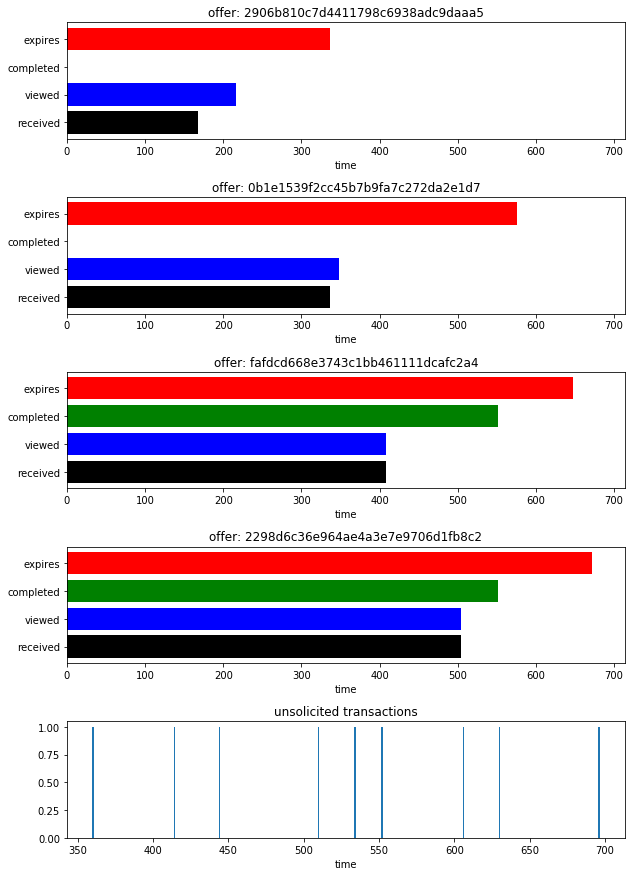

In [130]:
# person number 0
view_person_events(0)

The transcript shows Person 0 completing two offers (the two with green bars). Neither offer was completed before being viewed, and both offers were completed before they expired.

person: 0610b486422d4921ae7d2bf64640c50b
number of unsolicited transactions: 0


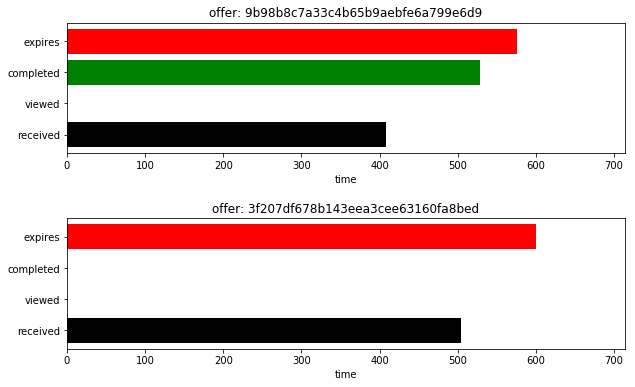

In [131]:
# person number 1
view_person_events(1)

The transcript shows Person 1 completing one offer (the one with the green bar). The offer was completed but never viewed and must be categorized as an 'unsuccessful' offer. The corresponding transaction is an 'unsolicited' transaction.

person: 38fe809add3b4fcf9315a9694bb96ff5
number of unsolicited transactions: 0


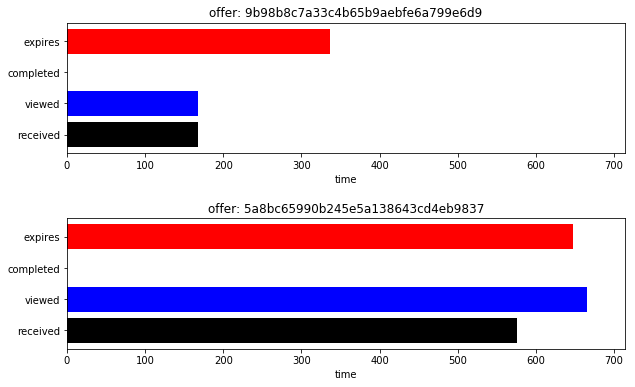

In [132]:
# person number 2
view_person_events(2)

The transcript does not show person 2 making any purchases.

person: 78afa995795e4d85b5d9ceeca43f5fef
number of unsolicited transactions: 6


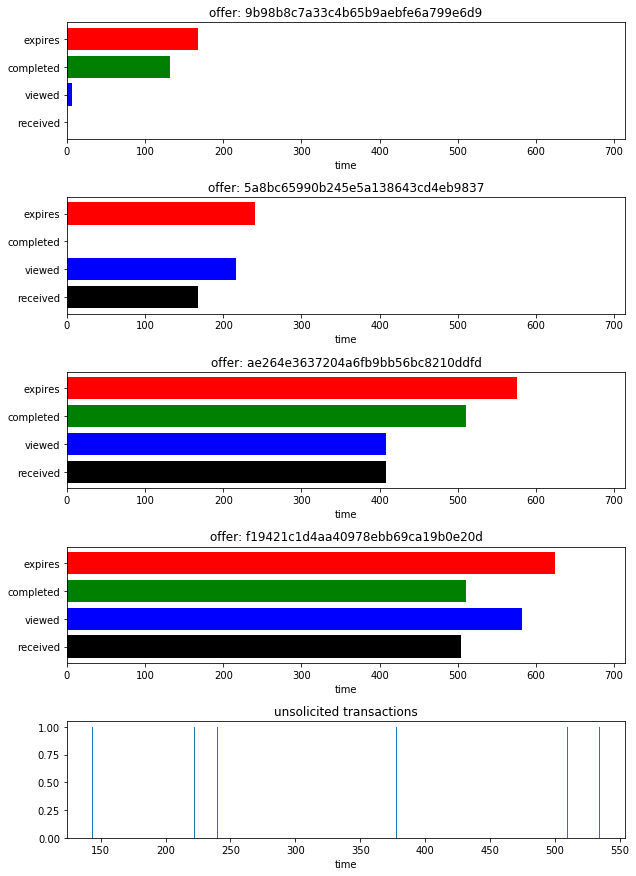

In [133]:
# person number 3
view_person_events(3)

The transcript shows person 3 completing three offers. The third offer (f1942...) was completed before it was viewed. It must be categorized as an 'unsuccessful' offer. The corresponding transaction is an 'unsolicited' transaction.

In [134]:
# look for all events that meet one of the following conditions:
# 1. not viewed AND completed (e.g. person 1)
# 2. viewed AND completed AND completed befor viewing (e.g. person 3)
# make a set of such events to add on to the data frame as unsolicited transactions, 
# and change these events from 'unsolicited' to 'lost'.

# get a list of indexes of relevant events
idx = df_all_person_offer[((df_all_person_offer['viewed'].isna()) & 
                           (~df_all_person_offer['completed'].isna())) |
                          ((~df_all_person_offer['viewed'].isna()) & 
                           (~df_all_person_offer['completed'].isna()) & 
                           (df_all_person_offer['completed'] < df_all_person_offer['viewed']))].index

# make a copy of the indexed events
df_to_add = df_all_person_offer.loc[idx].copy()
# change copy to 'unsolicited transaction'
df_to_add['id'] = 'unsolicited transaction'

# change original event from 'unsolicited' to 'lost'
df_all_person_offer.loc[idx,'unsolicited'] = [0]
df_all_person_offer.loc[idx,'lost'] = [1]

# concatenate the two data frames
df_all_person_offer = pd.concat([df_all_person_offer, df_to_add], ignore_index=True)

In [135]:
# merge the df_all_person_offer data frame and portfolio data frame
df_all_person_offer = df_all_person_offer.merge(portfolio, how='left', on='id')

In [136]:
# merge the df_all_person_offer data frame and profile data frame
df_all_person_offer = df_all_person_offer.merge(profile, how='left', left_on='person', right_on='id')

In [137]:
# cleanup columns

# drop column 'id_y'
df_all_person_offer.drop(columns='id_y', inplace=True)

In [138]:
# cleanup columns

# rename column'id_x' to 'offer'
df_all_person_offer.rename(columns={'id_x': 'offer'}, inplace=True)

In [139]:
# add categorical columns for gender
df_all_person_offer['M'] = df_all_person_offer['gender'].apply(lambda x: 1 if x == 'M' else 0)
df_all_person_offer['F'] = df_all_person_offer['gender'].apply(lambda x: 1 if x == 'F' else 0)
df_all_person_offer['O'] = df_all_person_offer['gender'].apply(lambda x: 1 if x == 'O' else 0)

### Define functions to use for plotting the results

In [140]:
# define a function to show outcomes as line chart
def make_outcomes_line_chart(df, x_var, y_var, title=''):
    '''
    shows a line chart of the y_var against the x_var. The offer (first 4 characters) is shown as the legend
    Inputs:
        df: dataframe to display
        x_var: (str) x-axis variable
        y_var: (str) y-axis variable
        title: (str) chart title
    Outputs: none
    '''
    plt.figure(figsize=(15,5))
    for offer in df['offer'].unique():
        d = df[df['offer'] == offer]
        plt.plot(d[x_var], d[y_var], label=offer[0:4])
        
    plt.legend(framealpha=0.5)
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    if title != '':
        plt.title(title)
    
    return

In [141]:
# define a function to show outcomes as bar chart
def make_outcomes_bar_chart(df, x_var, y_var, title=''):
    '''
    shows a bar chart of the y_var against the x_var. The offer (first 4 characters) is shown as the legend
    Inputs:
        df: dataframe to display
        x_var: (str) x-axis variable
        y_var: (str) y-axis variable
        title: (str) chart title
    Outputs: none
    '''
    # set up values of the x-axis variable
    n_xvars = len(df[x_var].unique())
    # set up the number of bars for each value of the x-axis variable
    n_offers =len(df['offer'].unique())
    # width of each bar
    width = 0.9 / n_offers
    # offset of first bar relative to tick for the x-axis variable
    x0 = -(n_offers - 1) / 2
    x = np.arange(n_xvars)
    
    plt.figure(figsize=(15,5))
    for i, offer in enumerate(df['offer'].unique()):
        # use a dict for plotting bar chart. if a certain age bracket is missing for the x_var, it will plot a zero for nan.
        mydict = {key: np.nan for key in df[x_var].unique()}
        d = df[df['offer'] == offer]
        for j in d[x_var].unique():
            mydict[j] = d[d[x_var] == j][y_var].values[0]
        plt.bar(x + x0 * width, mydict.values(), width=width, label=offer[0:4])
        x0 += 1
        
    plt.legend(framealpha=0.5)
    plt.xticks(x, df[x_var])
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    if title != '':
        plt.title(title)
    
        
    return

### Define list of outcomes

In [142]:
outcomes = ['successful','unsuccessful','unsolicited','inconclusive','lost']

In [143]:
def display_outcomes_by_group(df, groups):
    '''
    groups the dataframe by the specified groups and calculates and displays the percent in each group
    Inputs:
        df: data frame for which statistics have to calculated and displayed per the specified groups
        groups: specified groups
    Outputs: data frame containing calculated statistics according to the specified grouping
    '''
    df_calc = df.groupby(groups)[outcomes].sum()
    df_calc['total'] = df_calc['successful'] + df_calc['unsuccessful'] + df_calc['inconclusive'] + \
        df_calc['unsolicited'] + df_calc['lost']
    df_calc['successful%'] = round(df_calc['successful'] / df_calc['total'] * 100, 0)
    df_calc['unsolicited%'] = round(df_calc['unsolicited'] / df_calc['total'] * 100, 0)
    df_calc['unsuccessful%'] = round(df_calc['unsuccessful'] / df_calc['total'] * 100, 0)
    df_calc['inconclusive%'] = round(df_calc['inconclusive'] / df_calc['total'] * 100, 0)
    df_calc['lost%'] = round(df_calc['lost'] / df_calc['total'] * 100, 0)

    return df_calc[pd.DataFrame(columns=outcomes).add_suffix('%').columns.tolist()]

### Display outcomes for each offer broken down by gender

In [144]:
# what do the outcomes look like, broken down by gender?
df_all_person_offer.groupby(['gender'])[outcomes].sum()

,successful,unsuccessful,unsolicited,inconclusive,lost
gender,,,,,
F,10361,7665,42968,579,8851
M,11521,13385,60164,1246,11977
O,390,297,1507,25,204


In [145]:
# convert the numbers to percentages
df_outcome_gender = display_outcomes_by_group(df_all_person_offer, ['offer', 'gender'])

In [146]:
df_outcome_gender.reset_index(inplace=True)

In [147]:
# what do the outcome percentages look like?
df_outcome_gender.head()

,offer,gender,successful%,unsuccessful%,unsolicited%,inconclusive%,lost%
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,21.0,6.0,0.0,4.0,70.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,M,17.0,7.0,0.0,3.0,73.0
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,O,35.0,10.0,0.0,3.0,52.0
3,2298d6c36e964ae4a3e7e9706d1fb8c2,F,67.0,15.0,0.0,3.0,16.0
4,2298d6c36e964ae4a3e7e9706d1fb8c2,M,58.0,24.0,0.0,6.0,12.0


In [148]:
# there are many lines,and some of the colors are difficult to distinguish in a line chart. replaced by bar chart below.
#make_outcomes_line_chart(df_outcome_gender, 'gender', 'successful%')

In [149]:
# there are many lines,and some of the colors are difficult to distinguish in a line chart. replaced by bar chart below.
#make_outcomes_line_chart(df_outcome_gender, 'gender', 'unsolicited%')

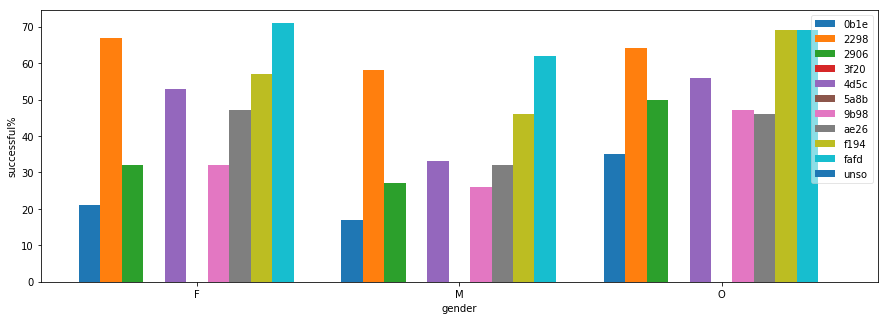

In [150]:
# make a chart of the percentage successful outcomes for each offer.
make_outcomes_bar_chart(df_outcome_gender, 'gender', 'successful%')

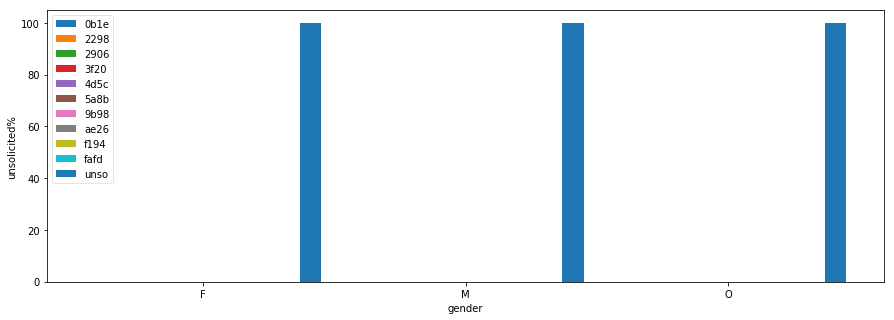

In [151]:
# make a chart of the percentage unsolicited outcomes for each offer.
make_outcomes_bar_chart(df_outcome_gender, 'gender', 'unsolicited%')

### Display outcomes for each offer broken down by became_member_year

In [152]:
# what do the outcomes look like, broken down by became_member_year?
df_all_person_offer.groupby(['became_member_year'])[outcomes].sum()

,successful,unsuccessful,unsolicited,inconclusive,lost
became_member_year,,,,,
2013,421,444,2929,36,385
2014,1013,1140,7011,86,868
2015,3100,2363,16961,157,2589
2016,6433,4175,31470,273,4878
2017,8640,10536,41669,1051,8772
2018,3616,8738,15843,1054,5509


The trend of enrolment increasing every year appears to be broken in 2018. Perhaps the profile data set does not cover all of 2018. Let's check the months in which enrolment occurred.

In [153]:
np.sort(profile[profile['became_member_year'] == 2018]['became_member_month'].unique())

array([1, 2, 3, 4, 5, 6, 7])

Yup, the profile data set only contains enrolment through July 2018. The test was conducted in August 2018, perhaps.

In [154]:
# convert the numbers to percentages
df_outcome_year = display_outcomes_by_group(df_all_person_offer, ['offer', 'became_member_year'])

In [155]:
df_outcome_year.reset_index(inplace=True)

In [156]:
# what do the outcome percentages look like?
df_outcome_year.head()

,offer,became_member_year,successful%,unsuccessful%,unsolicited%,inconclusive%,lost%
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,2013,14.0,5.0,0.0,3.0,78.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,2014,18.0,5.0,0.0,5.0,73.0
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,2015,18.0,6.0,0.0,2.0,73.0
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,2016,25.0,6.0,0.0,3.0,67.0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,2017,16.0,10.0,0.0,5.0,69.0


In [157]:
# there are many lines,and some of the colors are difficult to distinguish in a line chart. replaced by bar chart below.
#make_outcomes_line_chart(df_outcome_year, 'became_member_year', 'successful%')

In [158]:
# there are many lines,and some of the colors are difficult to distinguish in a line chart. replaced by bar chart below.
#make_outcomes_line_chart(df_outcome_year, 'became_member_year', 'unsolicited%')

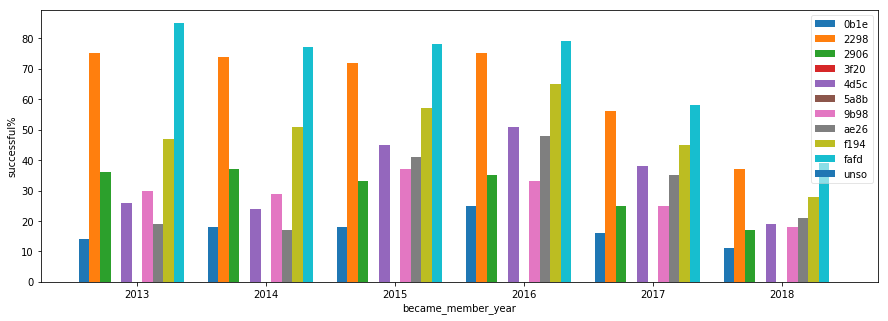

In [159]:
# make a chart of the percentage successful outcomes for each offer.
make_outcomes_bar_chart(df_outcome_year, 'became_member_year', 'successful%')

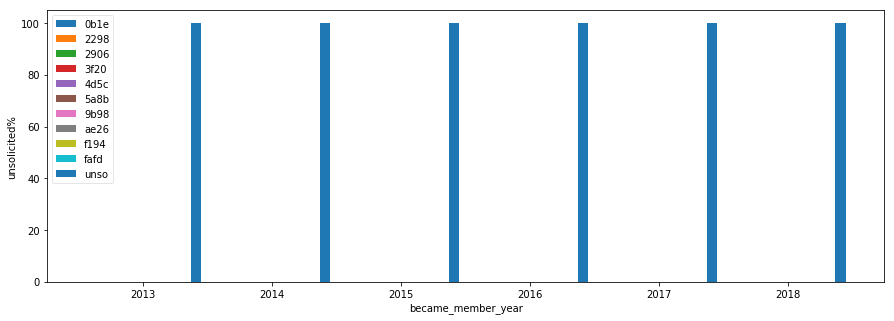

In [160]:
# make a chart of the percentage unsolicited outcomes for each offer.
make_outcomes_bar_chart(df_outcome_year, 'became_member_year', 'unsolicited%')

### Display outcomes for each offer broken down by income bracket

In [161]:
# check the income statistics - use it to define income brackets
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [162]:
# add column to df_all_person_offer for the income brackets
income_brackets = [(30000,49999), (50000,69999), (70000,89999), (90000,109999),(110000,120000)]

def pick_income_bracket(income):
    '''
    selects the number of the income bracket based on income brackets and income
    Input: income
    Output: bracket number
    '''
    if np.isnan(income):
        bracket_num = np.nan
    else:
        for i, bracket in enumerate(income_brackets):
            low = income_brackets[i][0]
            high = income_brackets[i][1]
            if (income >= low) & (income <= high):
                bracket_num = str(i)
                break
            
    return bracket_num
            

for i, bracket in income_brackets:
    df_all_person_offer['income bracket'] = df_all_person_offer['income'].apply(lambda x: pick_income_bracket(x))

In [163]:
# what do the outcomes look like, broken down by income bracket?
df_all_person_offer.groupby(['income bracket'])[outcomes].sum()

,successful,unsuccessful,unsolicited,inconclusive,lost
income bracket,,,,,
0,4040,6200,31012,622,6105
1,7656,7850,37840,684,6238
2,6565,4753,22927,377,5088
3,3154,2068,9947,147,2592
4,857,476,2913,20,1009


In [164]:
# convert the numbers to percentages
df_outcome_income = display_outcomes_by_group(df_all_person_offer, ['offer', 'income bracket'])

In [165]:
df_outcome_income.reset_index(inplace=True)

In [166]:
# what do the outcome percentages look like?
df_outcome_income.head()

,offer,income bracket,successful%,unsuccessful%,unsolicited%,inconclusive%,lost%
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,8.0,4.0,0.0,2.0,86.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,22.0,8.0,0.0,4.0,66.0
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,2,25.0,7.0,0.0,4.0,63.0
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,3,22.0,6.0,0.0,4.0,68.0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,9.0,2.0,0.0,0.0,89.0


In [167]:
# there are many lines,and some of the colors are difficult to distinguish in a line chart. replaced by bar chart below.
#make_outcomes_line_chart(df_outcome_income, 'income bracket', 'successful%')

In [168]:
# there are many lines,and some of the colors are difficult to distinguish in a line chart. replaced by bar chart below.
#make_outcomes_line_chart(df_outcome_income, 'income bracket', 'unsolicited%')

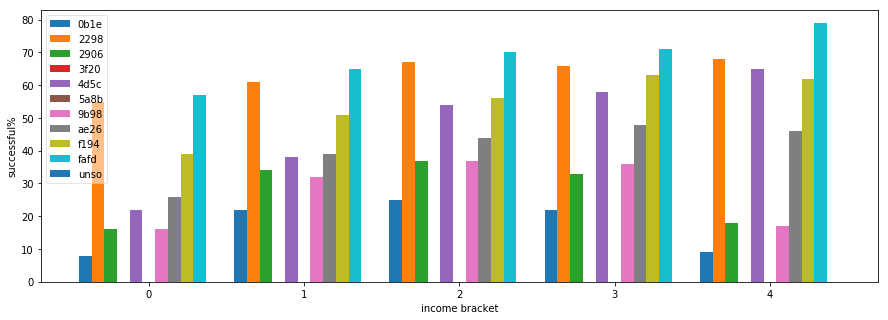

In [169]:
# make a chart of the percentage successful outcomes for each offer.
make_outcomes_bar_chart(df_outcome_income, 'income bracket', 'successful%')

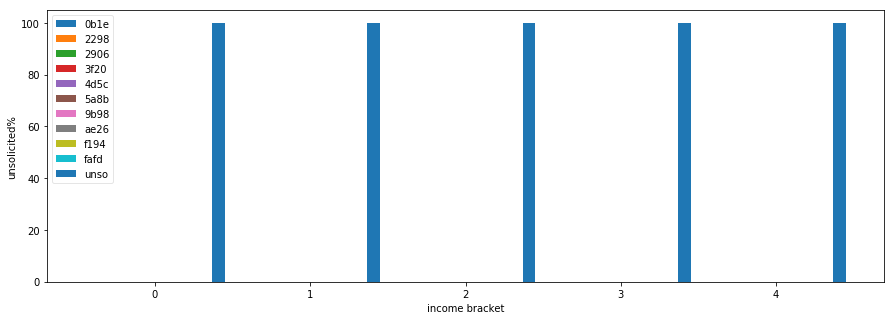

In [170]:
# make a chart of the percentage unsolicited outcomes for each offer.
make_outcomes_bar_chart(df_outcome_income, 'income bracket', 'unsolicited%')

### Display outcomes for each offer broken down by age bracket

In [171]:
# check the age statistics - use it to define age brackets
profile['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [172]:
# add column to df_all_person_offer for the age brackets
age_brackets = [(18,24), (25,34), (35,44), (45,54), (55,64), (65,74), (75,84), (85,104)]

def pick_age_bracket(age):
    '''
    selects the number of the age bracket based on age brackets and age
    Input: age
    Output: bracket number
    '''
    if np.isnan(age):
        bracket_num = np.nan
    else:
        for i, bracket in enumerate(age_brackets):
            if (age >= age_brackets[i][0]) & (age <= age_brackets[i][1]):
                bracket_num = str(i)
                break
            
    return bracket_num
            

for i, bracket in age_brackets:
    df_all_person_offer['age bracket'] = df_all_person_offer['age'].apply(lambda x: pick_age_bracket(x))

In [173]:
# what do the outcomes look like, broken down by age bracket?
df_all_person_offer.groupby(['age bracket'])[outcomes].sum()

,successful,unsuccessful,unsolicited,inconclusive,lost
age bracket,,,,,
0,960,1464,7410,114,1400
1,1614,2091,11949,232,2291
2,2878,2895,14459,251,2357
3,4701,4333,20064,382,4002
4,5446,4693,22518,404,4920
5,3788,3422,16201,282,3502
6,1948,1693,8220,129,1695
7,937,756,3818,56,865


In [174]:
# convert the numbers to percentages
df_outcome_age = display_outcomes_by_group(df_all_person_offer, ['offer', 'age bracket'])

In [175]:
df_outcome_age.reset_index(inplace=True)

In [176]:
# what do the outcome percentages look like?
df_outcome_age.head()

,offer,age bracket,successful%,unsuccessful%,unsolicited%,inconclusive%,lost%
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,11.0,2.0,0.0,1.0,86.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,8.0,5.0,0.0,2.0,85.0
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,2,20.0,8.0,0.0,4.0,69.0
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,3,22.0,7.0,0.0,4.0,67.0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,21.0,7.0,0.0,5.0,67.0


In [177]:
# there are many lines,and some of the colors are difficult to distinguish in a line chart. replaced by bar chart below.
#make_outcomes_line_chart(df_outcome_age, 'age bracket', 'successful%')

In [178]:
# there are many lines,and some of the colors are difficult to distinguish in a line chart. replaced by bar chart below.
#make_outcomes_line_chart(df_outcome_age, 'age bracket', 'unsolicited%')

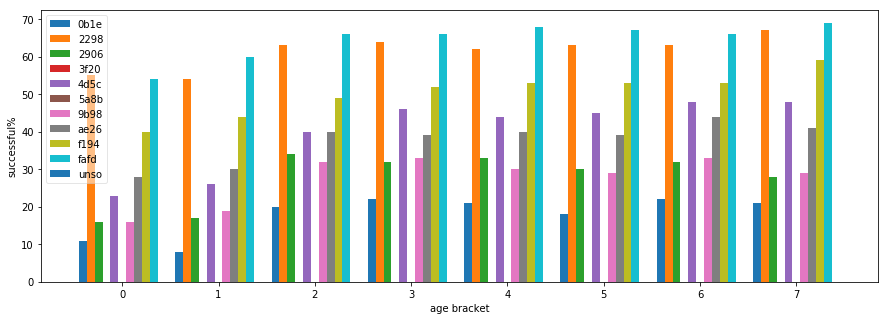

In [179]:
# make a chart of the percentage successful outcomes for each offer.
make_outcomes_bar_chart(df_outcome_age, 'age bracket', 'successful%')

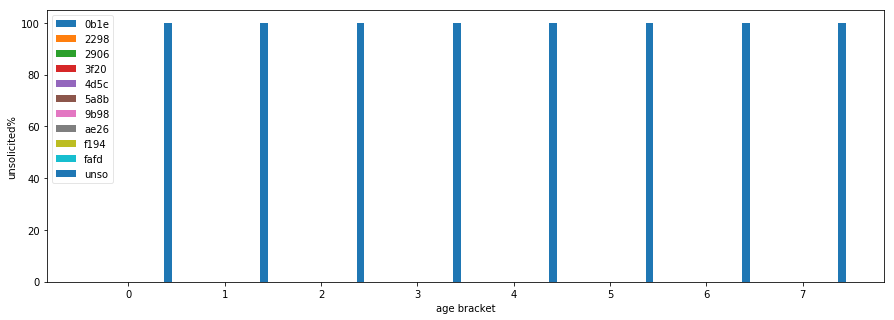

In [180]:
# make a chart of the percentage unsolicited outcomes for each offer.
make_outcomes_bar_chart(df_outcome_age, 'age bracket', 'unsolicited%')

### Display outcomes for each offer broken down by gender and income bracket

In [181]:
# convert the numbers to percentages
df_outcome_gender_income = display_outcomes_by_group(df_all_person_offer, ['offer','gender','income bracket'])

In [182]:
df_outcome_gender_income.reset_index(inplace=True)

In [183]:
# what do the outcome percentages look like?
df_outcome_gender_income.head()

,offer,gender,income bracket,successful%,unsuccessful%,unsolicited%,inconclusive%,lost%
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,0,12.0,4.0,0.0,2.0,82.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,1,27.0,7.0,0.0,5.0,61.0
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,2,23.0,6.0,0.0,4.0,67.0
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,3,19.0,5.0,0.0,4.0,72.0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,4,10.0,2.0,0.0,1.0,87.0


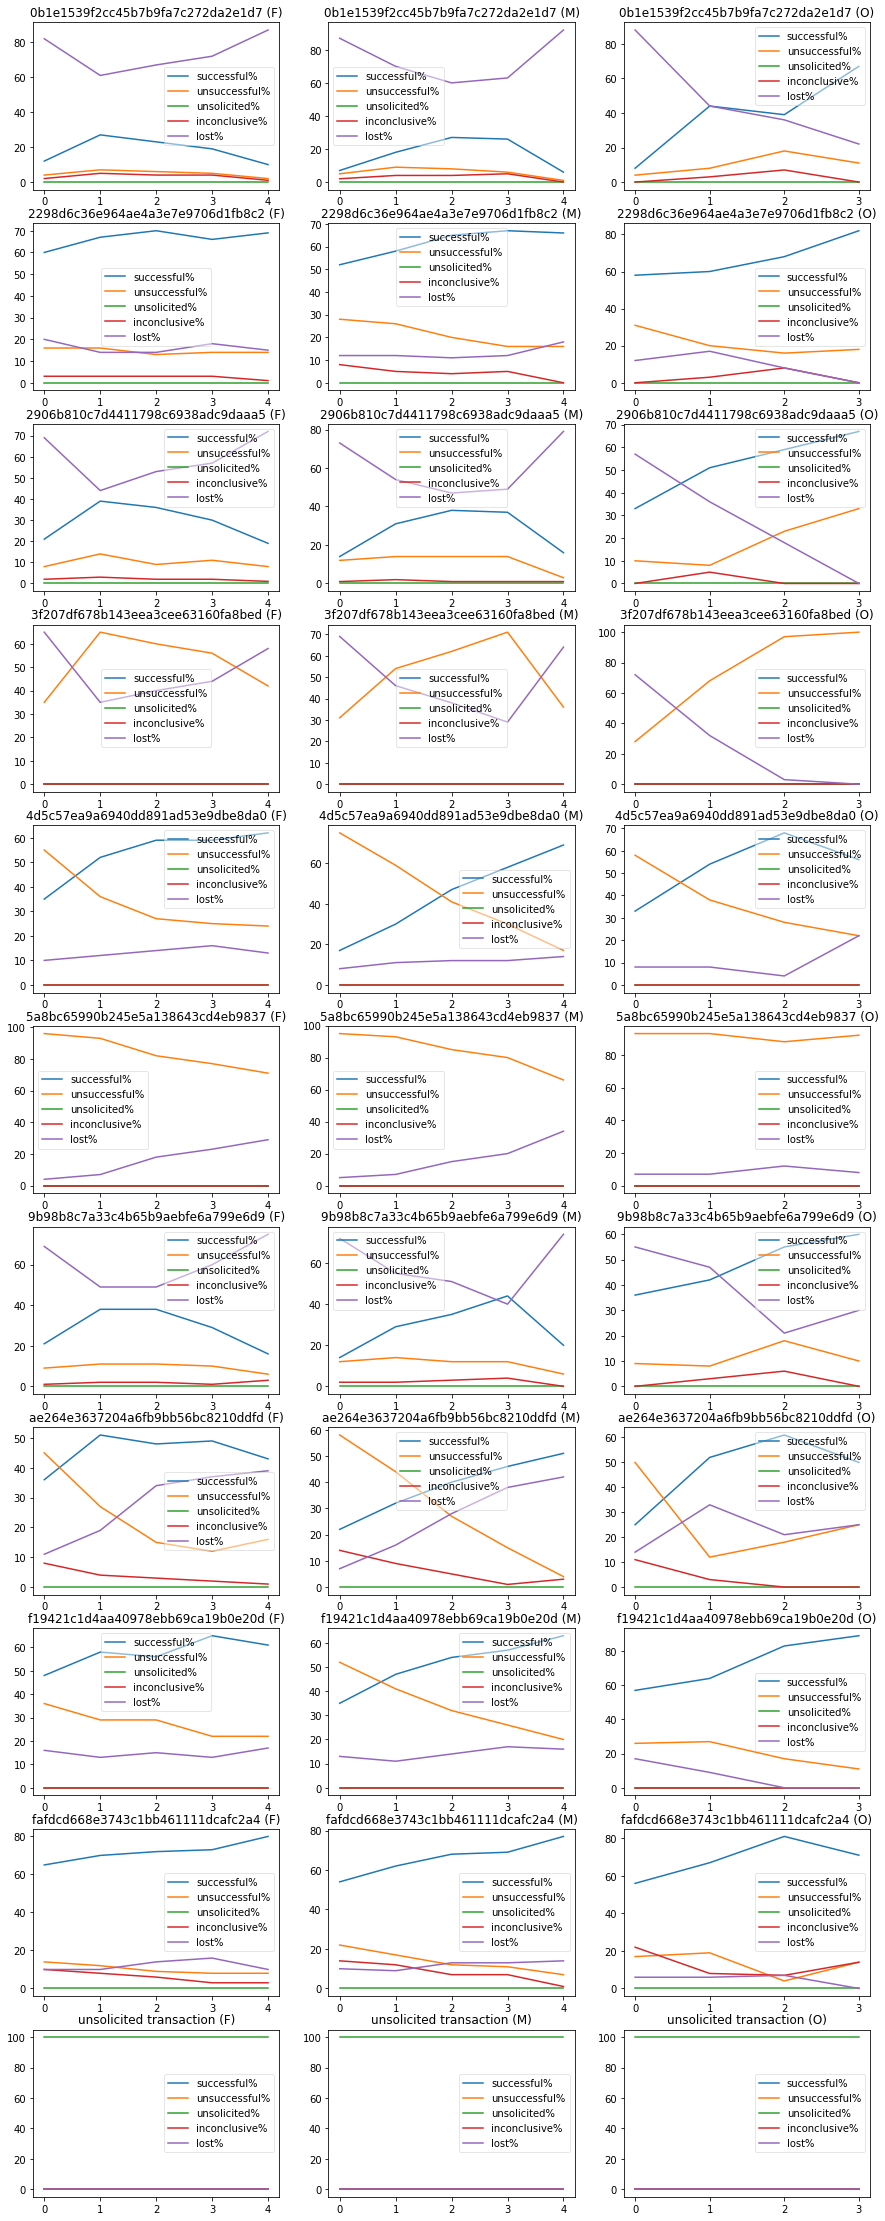

In [184]:
n_gender = df_outcome_gender_income['gender'].nunique()
n_offer = df_outcome_gender_income['offer'].nunique()
i_plot = 0
plt.figure(figsize=(15,40))
for offer in df_outcome_gender_income['offer'].unique():
    for gender in df_outcome_gender_income['gender'].unique():
        i_plot += 1
        plt.subplot(n_offer, n_gender, i_plot)
        df = df_outcome_gender_income[(df_outcome_gender_income['offer'] == offer) & (df_outcome_gender_income['gender'] == gender)]
        plt.plot(df['income bracket'], df['successful%'])
        plt.plot(df['income bracket'], df['unsuccessful%'])
        plt.plot(df['income bracket'], df['unsolicited%'])
        plt.plot(df['income bracket'], df['inconclusive%'])
        plt.plot(df['income bracket'], df['lost%'])
        plt.title(offer + ' (' + gender + ')')
        plt.legend(framealpha=0.5)

In [185]:
# there are many lines,and some of the colors are difficult to distinguish in a line chart. replaced by bar chart below.
#for gender in df_outcome_gender_income['gender'].unique():
#    make_outcomes_line_chart(df_outcome_gender_income[df_outcome_gender_income['gender'] == gender], 'income bracket', 'successful%', gender)

In [186]:
# there are many lines,and some of the colors are difficult to distinguish in a line chart. replaced by bar chart below.
#for gender in df_outcome_gender_income['gender'].unique():
#    make_outcomes_line_chart(df_outcome_gender_income[df_outcome_gender_income['gender'] == gender], 'income bracket', 'unsolicited%', gender)

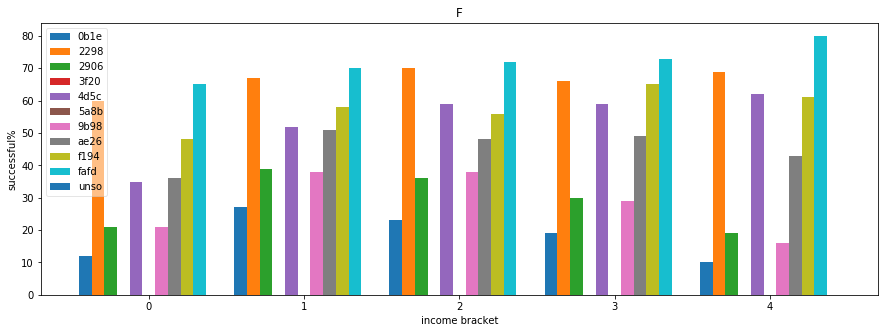

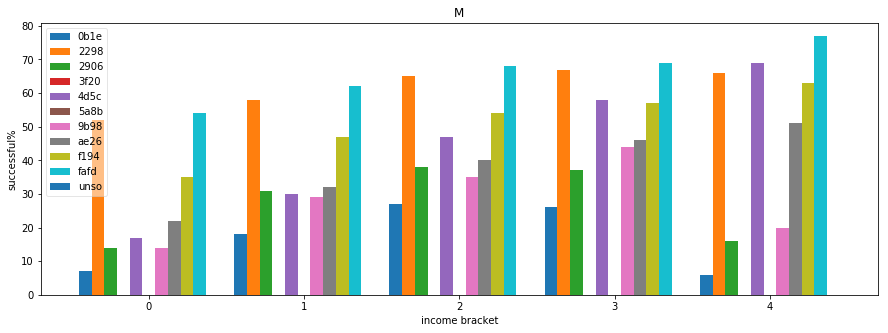

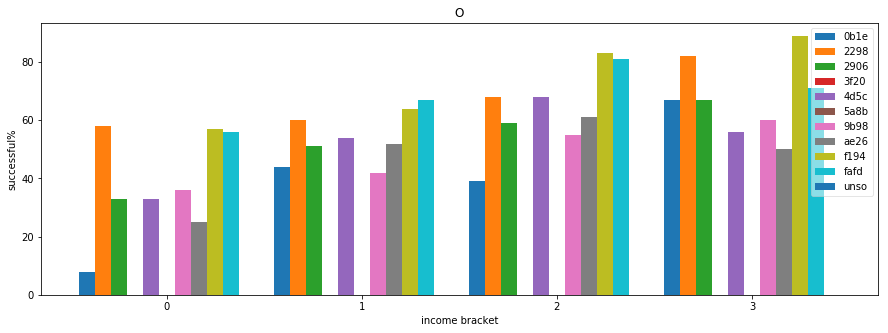

In [187]:
# make a chart of the percentage successful outcomes for each offer.
for gender in df_outcome_gender_income['gender'].unique():
    make_outcomes_bar_chart(df_outcome_gender_income[df_outcome_gender_income['gender'] == gender], 'income bracket', 'successful%', gender)

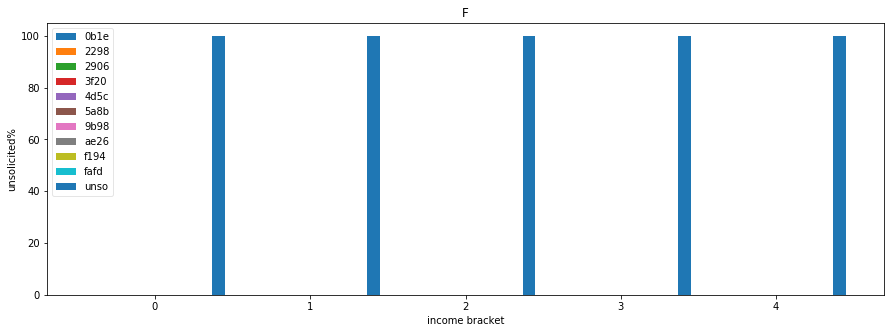

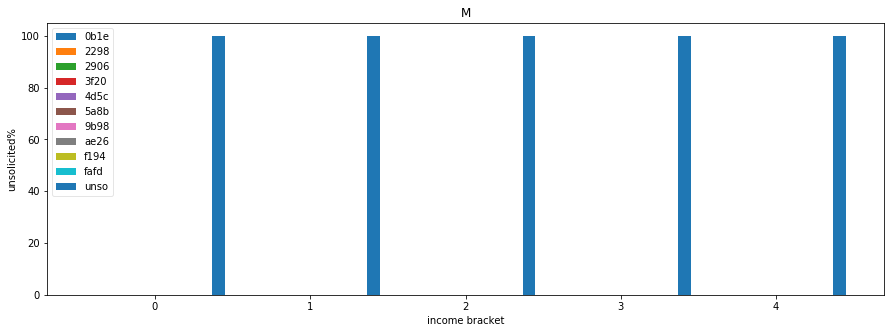

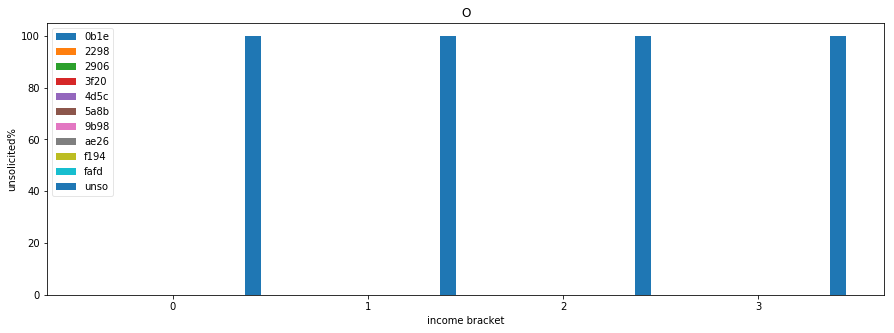

In [188]:
# make a chart of the percentage unsolicited outcomes for each offer.
for gender in df_outcome_gender_income['gender'].unique():
    make_outcomes_bar_chart(df_outcome_gender_income[df_outcome_gender_income['gender'] == gender], 'income bracket', 'unsolicited%', gender)

### Display outcomes for each offer broken down by gender and age bracket

In [189]:
# convert the numbers to percentages
df_outcome_gender_age = display_outcomes_by_group(df_all_person_offer, ['offer','gender','age bracket'])

In [190]:
df_outcome_gender_age.reset_index(inplace=True)

In [191]:
# what do the outcome percentages look like?
df_outcome_gender_age.head()

,offer,gender,age bracket,successful%,unsuccessful%,unsolicited%,inconclusive%,lost%
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,0,13.0,3.0,0.0,1.0,84.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,1,13.0,4.0,0.0,2.0,82.0
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,2,26.0,8.0,0.0,4.0,63.0
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,3,22.0,6.0,0.0,4.0,68.0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,4,22.0,6.0,0.0,4.0,68.0


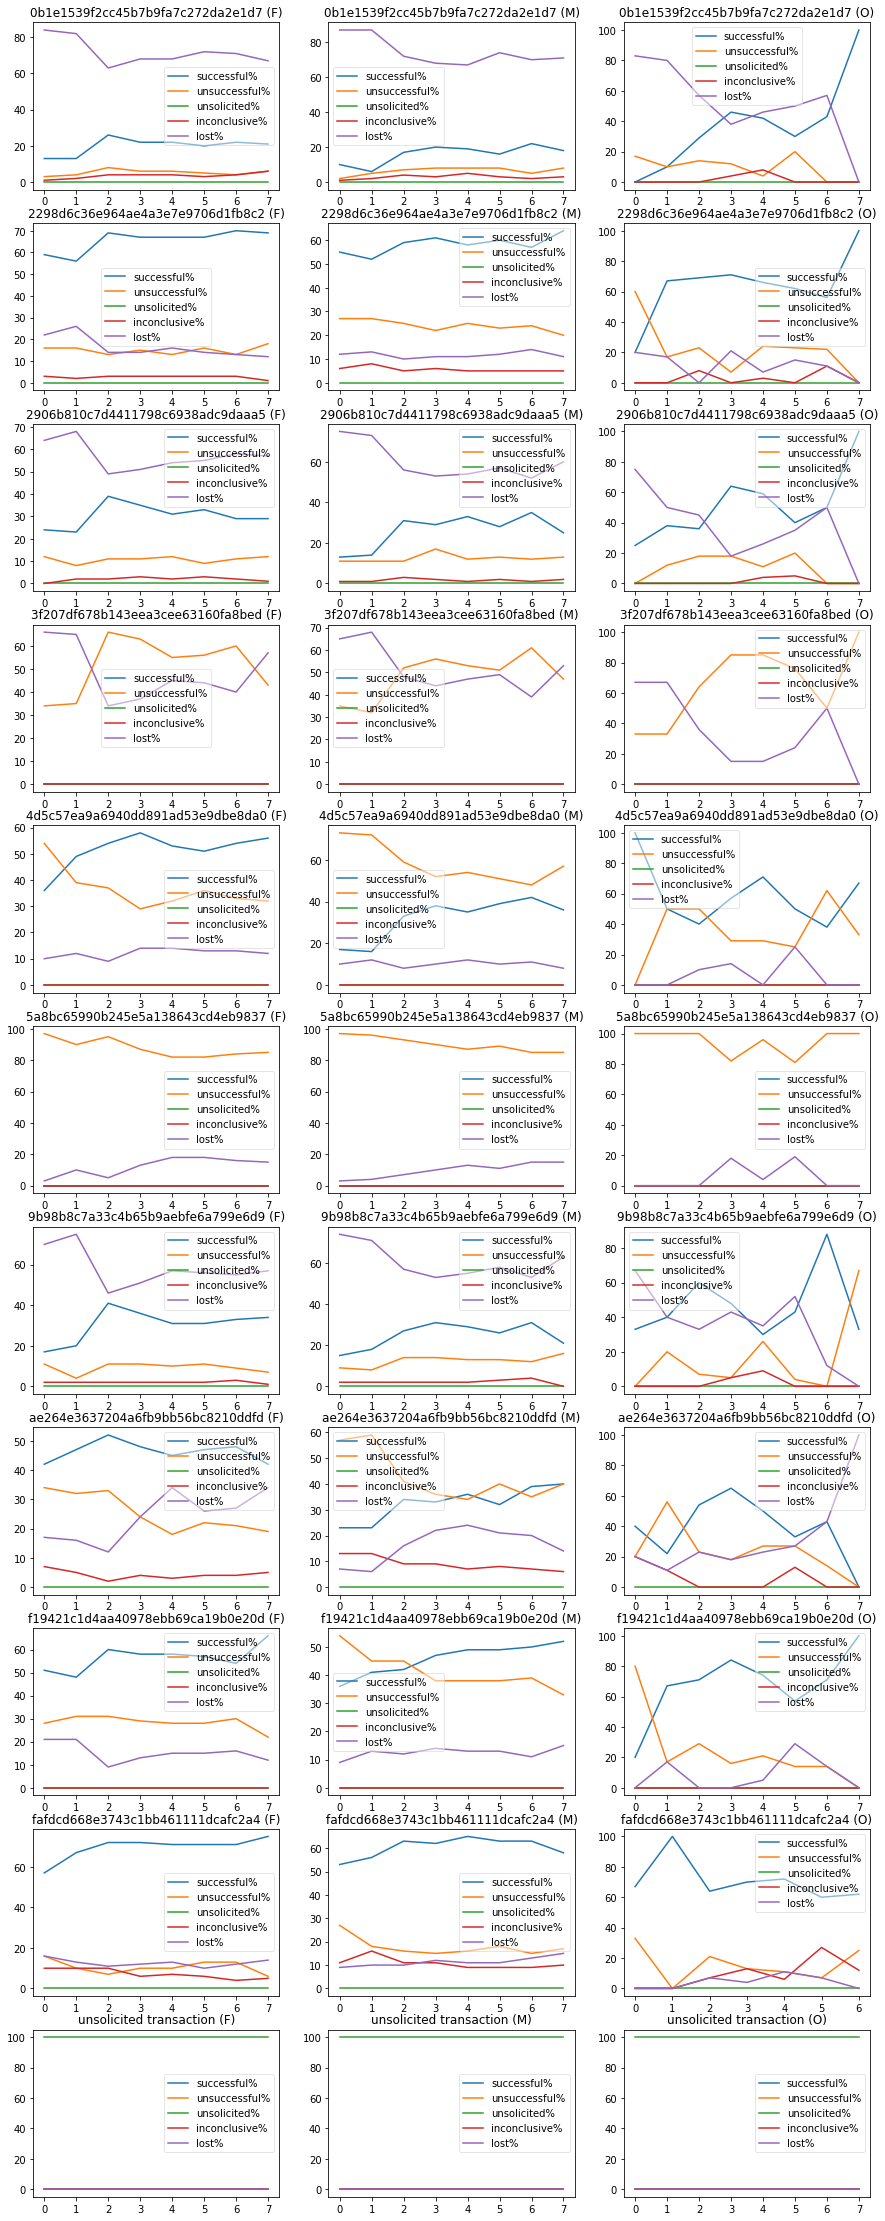

In [192]:
n_gender = df_outcome_gender_age['gender'].nunique()
n_offer = df_outcome_gender_age['offer'].nunique()
i_plot = 0
plt.figure(figsize=(15,40))
for offer in df_outcome_gender_age['offer'].unique():
    for gender in df_outcome_gender_age['gender'].unique():
        i_plot += 1
        plt.subplot(n_offer, n_gender, i_plot)
        df = df_outcome_gender_age[(df_outcome_gender_age['offer'] == offer) & (df_outcome_gender_age['gender'] == gender)]
        plt.plot(df['age bracket'], df['successful%'])
        plt.plot(df['age bracket'], df['unsuccessful%'])
        plt.plot(df['age bracket'], df['unsolicited%'])
        plt.plot(df['age bracket'], df['inconclusive%'])
        plt.plot(df['age bracket'], df['lost%'])
        plt.title(offer + ' (' + gender + ')')
        plt.legend(framealpha=0.5)  

In [193]:
# there are many lines,and some of the colors are difficult to distinguish in a line chart. replaced by bar chart below.
#for gender in df_outcome_gender_age['gender'].unique():
#    make_outcomes_line_chart(df_outcome_gender_age[df_outcome_gender_age['gender'] == gender], 'age bracket', 'successful%', gender)

In [194]:
# there are many lines,and some of the colors are difficult to distinguish in a line chart. replaced by bar chart below.
#for gender in df_outcome_gender_age['gender'].unique():
#    make_outcomes_bar_chart(df_outcome_gender_age[df_outcome_gender_age['gender'] == gender], 'age bracket', 'successful%', gender)

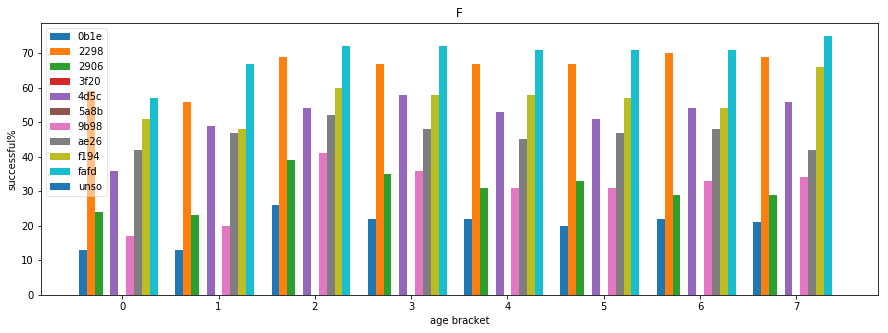

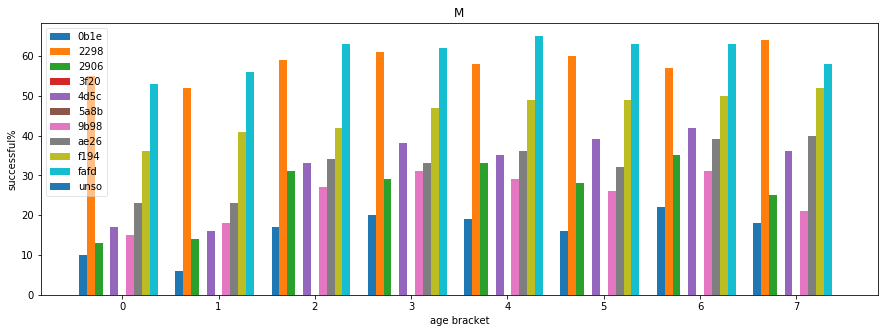

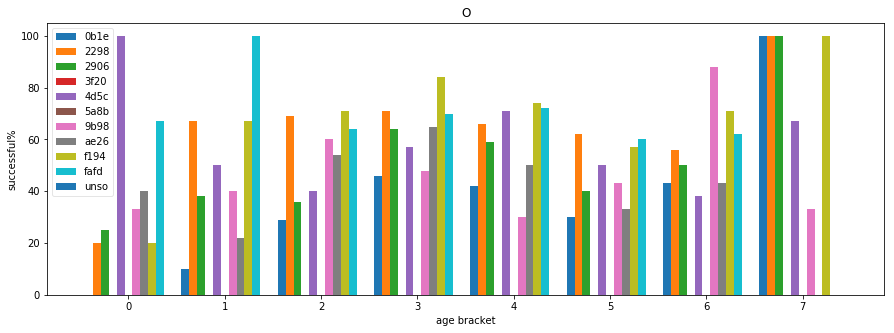

In [195]:
# make a chart of the percentage successful outcomes for each offer.
for gender in df_outcome_gender_age['gender'].unique():
    make_outcomes_bar_chart(df_outcome_gender_age[df_outcome_gender_age['gender'] == gender], 'age bracket', 'successful%', gender)

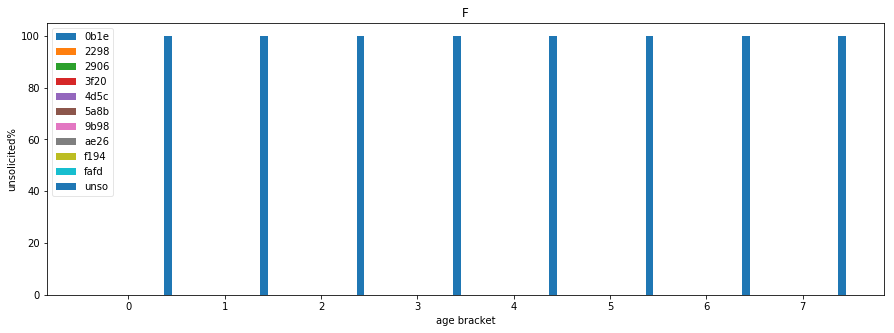

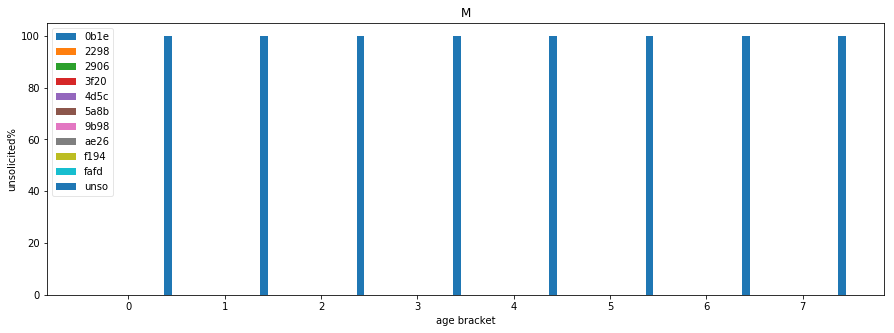

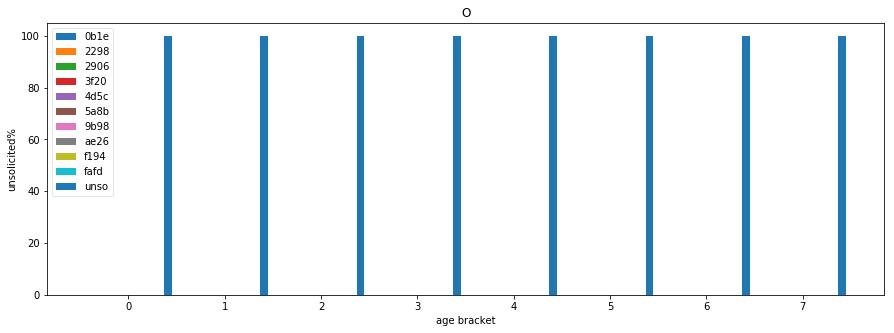

In [196]:
# make a chart of the percentage unsolicited outcomes for each offer.
for gender in df_outcome_gender_age['gender'].unique():
    make_outcomes_bar_chart(df_outcome_gender_age[df_outcome_gender_age['gender'] == gender], 'age bracket', 'unsolicited%', gender)

### Take a look at how the categorization overlays against the clusters suggested by the PCA performed earlier.

Inspecting the loadings, PC1 and PC3 provide the best differentiation based on age and income. If the PC3 score is plotted on the y-axis and the PC1 score on the x-axis, then:
1. Lower left has high income
2. Upper left has high age
3. Lower right has low age
4. Upper right has low income.

In [259]:
def plot_outcome_and_all_persons_PC(df_all, df_outcome, offers, genders, outcome='successful', pc_x=1, pc_y=3):
    '''
    '''
    n_gender = len(genders)
    n_offer = len(offers)
    i = 0

    plt.figure(figsize=(20,70))        

    for offer in offers:
        for gender in genders:
            i += 1
            scores = pca.transform(sc.transform(df_all[(df_all[gender] == 1)][['age','income','M','F','O']]))
        
            X_outcome = df_outcome[(df_outcome['offer'] == offer) & (df_outcome[gender] == 1) & 
                                         (df_outcome[outcome] == 1)][['age','income','M','F','O']].dropna(axis=0).copy()
            if X_outcome.shape[0] > 0:
                X_outcome_scaled = sc.transform(X_outcome)
                scores_outcome = pca.transform(X_outcome_scaled)
                plt.subplot(n_offer, n_gender, i)
                plt.scatter(scores[:,pc_x], scores[:,pc_y], marker='o', color='blue', label='all persons')
                plt.scatter(scores_outcome[:,pc_x], scores_outcome[:,pc_y], marker='.', color='red', label=outcome)
                plt.legend()
                plt.xlabel('PC' + str(pc_x))
                plt.ylabel('PC' + str(pc_y))
                plt.title(offer + ' (' + gender + ')');

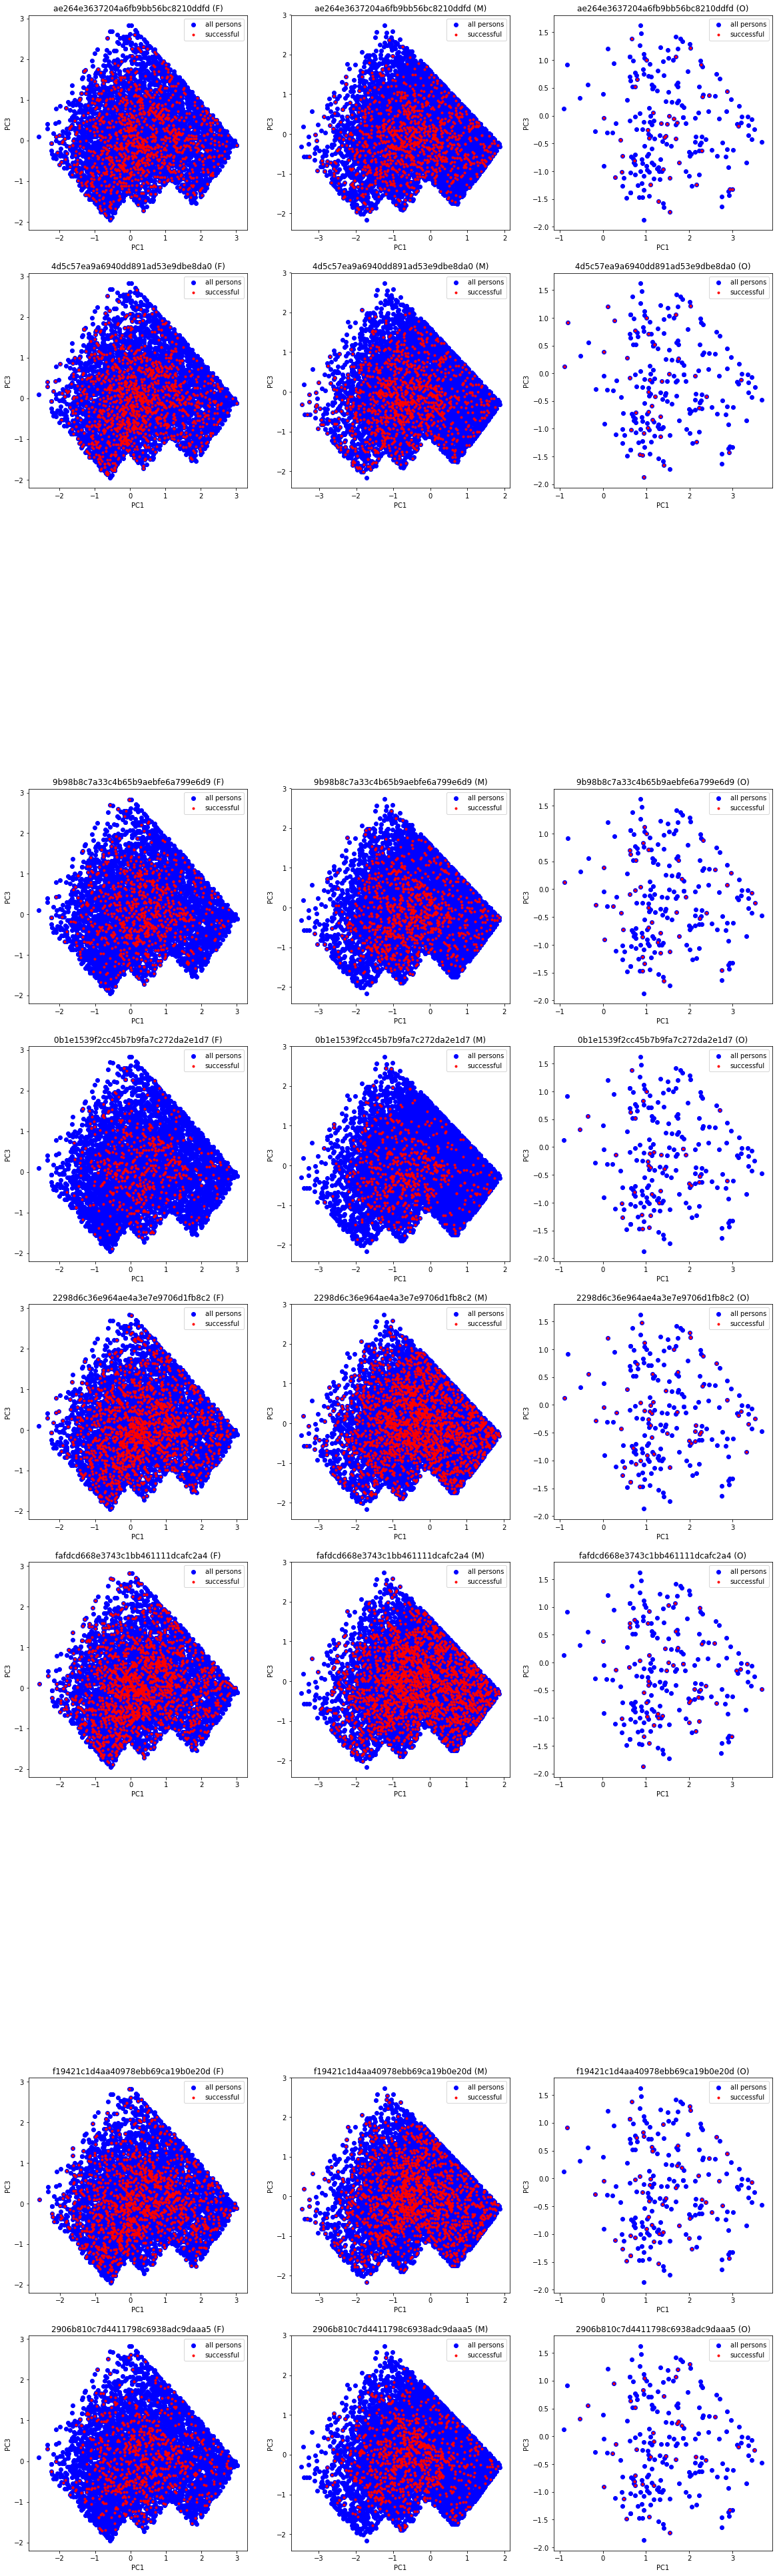

In [260]:
plot_outcome_and_all_persons_PC(df_profile_groups, df_all_person_offer, portfolio['id'].unique(), 
                             profile[~profile['gender'].isna()]['gender'].unique(), outcome='successful')